In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy.random import choice
import seaborn as sns
from itertools import combinations
from statannotations.Annotator import Annotator
from matplotlib import colors



/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Define Functions

In [2]:
demographics = gpd.read_file("inmap_demographics.shp")
dem_colnames = ['ID', 'White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000',
       'Total Households', 'Median Income', 'index_right', 'REGION',
       'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON','geometry']
demographics.columns = dem_colnames
demographics["Region"] = ""
demographics.loc[demographics.DIVISION=='1',"Region"] = "New England"
demographics.loc[demographics.DIVISION=='2',"Region"] = "Middle Atlantic"
demographics.loc[demographics.DIVISION=='3',"Region"] = "East North Central"
demographics.loc[demographics.DIVISION=='4',"Region"] = "West North Central"
demographics.loc[demographics.DIVISION=='5',"Region"] = "South Atlantic"
demographics.loc[demographics.DIVISION=='6',"Region"] = "East South Central"
demographics.loc[demographics.DIVISION=='7',"Region"] = "West South Central"
demographics.loc[demographics.DIVISION=='8',"Region"] = "Mountain"
demographics.loc[demographics.DIVISION=='9',"Region"] = "Pacific"

demographics["Big Region"] = ""
demographics.loc[demographics.DIVISION=='1',"Big Region"] = "Northeast"
demographics.loc[demographics.DIVISION=='2',"Big Region"] = "Northeast"
demographics.loc[demographics.DIVISION=='3',"Big Region"] = "Midwest"
demographics.loc[demographics.DIVISION=='4',"Big Region"] = "Midwest"
demographics.loc[demographics.DIVISION=='5',"Big Region"] = "South"
demographics.loc[demographics.DIVISION=='6',"Big Region"] = "South"
demographics.loc[demographics.DIVISION=='7',"Big Region"] = "South"
demographics.loc[demographics.DIVISION=='8',"Big Region"] = "West"
demographics.loc[demographics.DIVISION=='9',"Big Region"] = "West"

In [3]:
def net_benefits(diesel_deaths, elec_deaths):
    net_benefit= diesel_deaths[["Mortality","Population","geometry"]].copy()
    net_benefit["net_deathsK"] = elec_deaths["TotalDeathsK"] - diesel_deaths["deathsK"]
    net_benefit["net_deathsK_pc"] = net_benefit["net_deathsK"]/net_benefit["Population"]*100000
    net_benefit["deathsK"] = net_benefit["net_deathsK"]
    return net_benefit

def plot_net_benefits(net_benefit, commflow):    
    f, ax = plt.subplots(1,1, figsize = (15,15))
    max_val = net_benefit.net_deathsK_pc.max()
    min_val = net_benefit.net_deathsK_pc.min()
    lim = max(abs(max_val), abs(min_val))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    net_benefit.plot(column = "net_deathsK_pc", cmap = "bwr", legend = True, ax = ax,vmin = -1*lim, vmax = lim, cax = cax)
    comm = commflow.split("-")
    ax.set_title(f"Net Deaths per Capita from Full Fleet Electrification (compared to new Diesel Fleet): {comm[0]}")
    ax.set_xticks([])
    ax.set_yticks([])   
    
    f.savefig(f"net_benefit_{comm[0]}.png")



In [4]:
def attach_demographics(df, demographics):
    df = df.to_crs(4326)
    result = df.merge(demographics, how = "inner", left_index = True, right_index = True)
    for c in ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000']:
        result[f"{c}_deathsK"] = result["deathsK"] * result[c]/100
        result[f"{c}_pop"] = result[c]/100*result["Population"]
        result[f"{c}_deathsK_pc"] = result[f"{c}_deathsK"]/result[f"{c}_pop"]*100000
    result = result.set_geometry("geometry_x", drop = True)
    result = result.drop(columns = ["geometry_y"])
    
    return result

In [5]:
def demographics_deaths_table(df): #df should be a dataframe with deaths and demographics
    dem_deaths = pd.DataFrame(columns = ["deaths","pop","deaths_pc","pop_pct"], index = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
           'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
           'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
           '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
           '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
           '100,000 - 149,999', '150,000 - 199,999', '>200,000'])
    for row in dem_deaths.index:
        dem_deaths.loc[row,"deaths"] = df[f"{row}_deathsK"].sum()
        dem_deaths.loc[row,"pop"] = df[f"{row}_pop"].sum()
        dem_deaths.loc[row,"deaths_pc"] = dem_deaths.loc[row,"deaths"]/dem_deaths.loc[row,"pop"]*100000
        dem_deaths.loc[row,"pop_pct"] = dem_deaths.loc[row,"pop"]/df["Population"].sum()*100

    totals = pd.Series({"deaths":df.deathsK.sum(), 
              "pop":df.Population.sum(),
              "deaths_pc":df.deathsK.sum()/df.Population.sum()*100000, "pop_pct":100})
    totals.name = "Totals"
    dem_deaths = dem_deaths.append(totals)
    dem_deaths["deaths_pct"] = dem_deaths["deaths"]/dem_deaths.loc["Totals","deaths"]*100
    
    return dem_deaths

In [6]:
def make_big_region_death_tables(df): #df should be a dataframe with deaths and demographics
    big_regional_deaths = pd.DataFrame(columns = demographics["Big Region"].unique(), index = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'])
    for region in big_regional_deaths.columns:
        for dem in big_regional_deaths.index:
            big_regional_deaths.loc[dem, region] = df.loc[df["Big Region"]==region,f"{dem}_deathsK"].sum()
    totals = pd.Series({region: df.loc[df["Big Region"]==region,"deathsK"].sum() for region in big_regional_deaths.columns})
    totals.name = "Totals"
    big_regional_deaths = big_regional_deaths.append(totals)


    big_regional_deaths_pc = pd.DataFrame(columns = demographics["Big Region"].unique(), index = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'])
    for region in big_regional_deaths_pc.columns:
        for dem in big_regional_deaths_pc.index:
            big_regional_deaths_pc.loc[dem, region] = df.loc[df["Big Region"]==region,f"{dem}_deathsK"].sum()/df.loc[df["Big Region"]==region,f"{dem}_pop"].sum()*100000
    totals = pd.Series({region: df.loc[df["Big Region"]==region,"deathsK"].sum()/df.loc[df["Big Region"]==region,"Population"].sum()*100000 for region in big_regional_deaths_pc.columns})
    totals.name = "Totals"
    big_regional_deaths_pc = big_regional_deaths_pc.append(totals)
    
    return big_regional_deaths, big_regional_deaths_pc



In [7]:
def make_region_death_tables(df): #df should be a dataframe with deaths and demographics
    big_regional_deaths = pd.DataFrame(columns = demographics["Region"].unique(), index = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'])
    for region in big_regional_deaths.columns:
        for dem in big_regional_deaths.index:
            big_regional_deaths.loc[dem, region] = df.loc[df["Region"]==region,f"{dem}_deathsK"].sum()
    totals = pd.Series({region: df.loc[df["Region"]==region,"deathsK"].sum() for region in big_regional_deaths.columns})
    totals.name = "Totals"
    big_regional_deaths = big_regional_deaths.append(totals)


    big_regional_deaths_pc = pd.DataFrame(columns = demographics["Region"].unique(), index = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'])
    for region in big_regional_deaths_pc.columns:
        for dem in big_regional_deaths_pc.index:
            big_regional_deaths_pc.loc[dem, region] = df.loc[df["Region"]==region,f"{dem}_deathsK"].sum()/df.loc[df["Region"]==region,f"{dem}_pop"].sum()*100000
    totals = pd.Series({region: df.loc[df["Region"]==region,"deathsK"].sum()/df.loc[df["Region"]==region,"Population"].sum()*100000 for region in big_regional_deaths_pc.columns})
    totals.name = "Totals"
    big_regional_deaths_pc = big_regional_deaths_pc.append(totals)
    
    return big_regional_deaths, big_regional_deaths_pc

In [8]:
def make_state_death_tables(df):
    state_deaths_pc = pd.DataFrame(columns = demographics["STATEFP"].unique(), index = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'])
    for state in state_deaths_pc.columns:
        for dem in state_deaths_pc.index:
            state_deaths_pc.loc[dem, state] = df.loc[df["STATEFP"]==state,f"{dem}_deathsK"].sum()/df.loc[df["STATEFP"]==state,f"{dem}_pop"].sum()*100000
    totals = pd.Series({state: df.loc[df["STATEFP"]==state,"deathsK"].sum()/df.loc[df["STATEFP"]==state,"Population"].sum()*100000 for state in state_deaths_pc.columns})
    totals.name = "Totals"
    state_deaths_pc = state_deaths_pc.append(totals)
    
    
    state_deaths = pd.DataFrame(columns = demographics["STATEFP"].unique(), index = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',
       '<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'])
    for state in state_deaths.columns:
        for dem in state_deaths.index:
            state_deaths.loc[dem, state] = df.loc[df["STATEFP"]==state,f"{dem}_deathsK"].sum()
    totals = pd.Series({state: df.loc[df["STATEFP"]==state,"deathsK"].sum() for state in state_deaths.columns})
    totals.name = "Totals"
    
    return state_deaths_pc, state_deaths

In [9]:
def make_state_deaths_income(state_deaths_c):
    state_deaths_race = state_deaths_c.loc[['<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'],:].T[1:]
    return state_deaths_race

In [10]:
def make_state_deaths_race(state_deaths_c):
    state_deaths_race = state_deaths_c.loc[['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct'],:].T[1:]
    return state_deaths_race

In [11]:
def add_highest_race(df):
    df = df.copy()
    # df["highest_race"] = ""
    df["max_deaths_pc"] = df.max(axis = 1)
    for state in df.index:
        # print(state)
        # print(df.loc[state,:])
        if df.loc[state,:].max() == df.loc[state,"White_pct"]:
            df.loc[state,"highest_race"] = "White"
        elif df.loc[state,:].max() == df.loc[state,"Black_pct"]:
            df.loc[state,"highest_race"] = "Black"
        elif df.loc[state,:].max() == df.loc[state,"Native_pct"]:
            df.loc[state,"highest_race"] = "Native"
        elif df.loc[state,:].max() == df.loc[state,"Asian_pct"]:
            df.loc[state,"highest_race"] = "Asian"
        elif df.loc[state,:].max() == df.loc[state,"Pac Islander_pct"]:
            df.loc[state,"highest_race"] = "Pac Islander"
        elif df.loc[state,:].max() == df.loc[state,"Two or More_pct"]:
            df.loc[state,"highest_race"] = "Two or More"
        elif df.loc[state,:].max() == df.loc[state,"Latino_pct"]:
            df.loc[state,"highest_race"] = "Latino"
    
    return df

In [12]:
def add_highest_income(df):
    df = df.copy()
    df["max_deaths_pc"] = df.max(axis = 1)
    for inc in df.index:
        if df.loc[inc,:].max() == df.loc[inc,'<10,000']:
            df.loc[inc,"highest_income"] = '<10,000'
        elif df.loc[inc,:].max() == df.loc[inc,'10,000-14,999']:
            df.loc[inc,"highest_income"] = '10,000-14,999'
        elif df.loc[inc,:].max() == df.loc[inc,'15,000 - 24,999']:
            df.loc[inc,"highest_income"] = '15,000 - 24,999'
        elif df.loc[inc,:].max() == df.loc[inc,'25,000 - 34,999']:
            df.loc[inc,"highest_income"] = '25,000 - 34,999'
        elif df.loc[inc,:].max() == df.loc[inc,'35,000 - 49,999']:
            df.loc[inc,"highest_income"] = '35,000 - 49,999'
        elif df.loc[inc,:].max() == df.loc[inc,'50,000 - 74,999']:
            df.loc[inc,"highest_income"] = '50,000 - 74,999'
        elif df.loc[inc,:].max() == df.loc[inc,'75,000 - 99,999']:
            df.loc[inc,"highest_income"] = '75,000 - 99,999'
        elif df.loc[inc,:].max() == df.loc[inc,'100,000 - 149,999']:
            df.loc[inc,"highest_income"] = '100,000 - 149,999'
        elif df.loc[inc,:].max() == df.loc[inc,'150,000 - 199,999']:
            df.loc[inc,"highest_income"] = '150,000 - 199,999'
        elif df.loc[inc,:].max() == df.loc[inc,'>200,000']:
            df.loc[inc,"highest_income"] = '>200,000'
    
    return df

In [13]:
def make_deaths_pc_diff_table_states(df, statefps): #df is the demographic table
    deaths_pc_diff = pd.DataFrame(columns = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct'], index = statefps, dtype = float)
    deaths_pc_diff_pct = pd.DataFrame(columns = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct'], index = statefps, dtype = float)
    for state in deaths_pc_diff.index:
        for race in deaths_pc_diff.columns:
            race_deaths_pc = df.loc[df.STATEFP==state,f"{race}_deathsK"].sum()/df.loc[df.STATEFP==state,f"{race}_pop"].sum()*100000
            total_deaths_pc = df.loc[df.STATEFP==state,"deathsK"].sum()/df.loc[df.STATEFP==state,"Population"].sum()*100000
            diff = race_deaths_pc - total_deaths_pc
            diff_pct = diff/total_deaths_pc*100
            deaths_pc_diff.loc[state,race] = diff
            deaths_pc_diff_pct.loc[state,race] = diff_pct
            
    deaths_pc_diff = states.merge(deaths_pc_diff, how = "right", left_on = "STATEFP", right_index = True)
    deaths_pc_diff_pct = states.merge(deaths_pc_diff_pct, how = "right", left_on = "STATEFP", right_index = True)
    return deaths_pc_diff, deaths_pc_diff_pct



## Read in results

In [14]:

elec_deaths = {}
diesel_deaths = {}
scenarios = ["base","NREL_mid","1980_coal"]
#
commodities = ['TOT Farm Products-Tons_22 All','TOT Food, Bev and Tobacco-Tons_22 All','TOT Stone Sand Gravel & Ores-Tons_22 All',
              'TOT Liquid and Gases-Tons_22 All', 'TOT Chemicals-Tons_22 All', 'TOT Logs & Oth Wood Prods-Tons_22 All', 
              'TOT Waste and Scrap-Tons_22 All', 'TOT Consumer Manuf-Tons_22 All',"TOT Durable Manuf (low tech)-Tons_22 All", 
               'TOT Durable Manuf (high tech)-Tons_22 All','TOT Motor and Other Veh-Tons_22 All', 'TOT Mixed Freight-Tons_22 All', 'TOT Tons_22 All']


for s in scenarios:
    elec_deaths[s] = {}
    for c in commodities:
        with open(f"Results/elec_deaths_{s}_{c}",'rb') as f:
            elec_deaths[s][c] = pickle.load(f)

scenarios = ["new_diesel", "fleet_avg"]

for s in scenarios:
    diesel_deaths[s] = {}
    for c in commodities:
        with open(f"Results/diesel_deaths_{s}_{c}",'rb') as f:
            diesel_deaths[s][c] = pickle.load(f) 



In [97]:
# ## Imports

diesel_deaths_i = {}

scenarios = ["fleet_avg"]


commodities = ['TOT Tons_22 Imp']
for s in scenarios:
    diesel_deaths_i[s] = {}
    for c in commodities:
        with open(f"Results/diesel_deaths_{s}_imports_{c}",'rb') as f:
            diesel_deaths_i[s][c] = pickle.load(f) 
            
diesel_deaths_e = {}
commodities = ['TOT Tons_22 Exp']
for s in scenarios:
    diesel_deaths_e[s] = {}
    for c in commodities:
        with open(f"Results/diesel_deaths_{s}_exports_{c}",'rb') as f:
            diesel_deaths_e[s][c] = pickle.load(f)




In [21]:
elec_co2 = {}
diesel_co2 = {}
scenarios = ["base","NREL_mid","1980_coal"]
#
commodities = ['TOT Farm Products-Tons_22 All','TOT Food, Bev and Tobacco-Tons_22 All','TOT Stone Sand Gravel & Ores-Tons_22 All',
              'TOT Liquid and Gases-Tons_22 All', 'TOT Chemicals-Tons_22 All', 'TOT Logs & Oth Wood Prods-Tons_22 All', 
              'TOT Waste and Scrap-Tons_22 All', 'TOT Consumer Manuf-Tons_22 All',"TOT Durable Manuf (low tech)-Tons_22 All", 
               'TOT Durable Manuf (high tech)-Tons_22 All','TOT Motor and Other Veh-Tons_22 All', 'TOT Mixed Freight-Tons_22 All', 'TOT Tons_22 All']


for s in scenarios:
    elec_co2[s] = {}

    for c in commodities:
        with open(f"Results/elec_co2_{s}_{c}",'rb') as f:
            elec_co2[s][c] = pickle.load(f)

scenarios = ["new_diesel", "fleet_avg"]

for s in scenarios:
    diesel_co2[s] = {}
    for c in commodities:
        with open(f"Results/diesel_co2_{s}_{c}",'rb') as f:
            diesel_co2[s][c] = pickle.load(f)["CO2"].sum()/1e3 





## Process results

In [ ]:
summary_table = pd.DataFrame(columns = ["flow","scenario","fuel","commodity","race","income","region","state","deaths","deaths_pc"], dtype = float)
scenarios = ["base","NREL_mid","1980_coal"]
#

commodities = ['TOT Farm Products-Tons_22 All','TOT Food, Bev and Tobacco-Tons_22 All','TOT Stone Sand Gravel & Ores-Tons_22 All',
              'TOT Liquid and Gases-Tons_22 All', 'TOT Chemicals-Tons_22 All', 'TOT Logs & Oth Wood Prods-Tons_22 All', 
              'TOT Waste and Scrap-Tons_22 All', 'TOT Consumer Manuf-Tons_22 All',"TOT Durable Manuf (low tech)-Tons_22 All", 
               'TOT Durable Manuf (high tech)-Tons_22 All','TOT Motor and Other Veh-Tons_22 All', 'TOT Mixed Freight-Tons_22 All']

races = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct']

incomes = ['<10,000',
       '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000']

states = ['06', '41', '53', '32', '04', '16', '49', '30', '35', '56',
       '08', '48', '31', '46', '40', '38', '20', '27', '19', '29', '05',
       '22', '55', '17', '28', '26', '47', '21', '18', '01', '12', '39',
       '13', '37', '51', '54', '45', '42', '36', '24', '11', '10', '34',
       '50', '09', '25', '33', '23', '44']


for s in scenarios:
    for c in commodities:
        df = elec_deaths[s][c]
        df = attach_demographics(df, demographics)
        dem_df = demographics_deaths_table(df)[["deaths","deaths_pc"]]
        dem_df["scenario"] = s
        dem_df["fuel"] = "electric"
        dem_df["commodity"] = c[:-4]
        dem_df["region"] = "All"
        dem_df["state"] = "All"
        dem_df["race"] = "All"
        dem_df["income"] = "All"
        dem_df["flow"] = "All"
        dem_df.loc[dem_df.index.isin(races),"race"] = dem_df.loc[dem_df.index.isin(races)].index
        dem_df.loc[dem_df.index.isin(incomes),"income"] = dem_df.loc[dem_df.index.isin(incomes)].index
        summary_table = pd.concat([summary_table,dem_df])
        
scenarios = ["new_diesel", "fleet_avg"]  
for s in scenarios:
     for c in commodities:
        df = diesel_deaths[s][c]
        df = attach_demographics(df, demographics)
        dem_df = demographics_deaths_table(df)[["deaths","deaths_pc"]]
        dem_df["scenario"] = s
        dem_df["fuel"] = "diesel"
        dem_df["commodity"] = c[:-4]
        dem_df["region"] = "All"
        dem_df["state"] = "All"
        dem_df["race"] = "All"
        dem_df["income"] = "All"
        dem_df["flow"] = "All"
        dem_df.loc[dem_df.index.isin(races),"race"] = dem_df.loc[dem_df.index.isin(races)].index
        dem_df.loc[dem_df.index.isin(incomes),"income"] = dem_df.loc[dem_df.index.isin(incomes)].index
        summary_table = pd.concat([summary_table,dem_df])   
        
summary_table["deaths"] = summary_table["deaths"].astype(float)
summary_table["deaths_pc"] = summary_table["deaths_pc"].astype(float)

In [ ]:
races = ['White_pct', 'Black_pct', 'Native_pct', 'Asian_pct',
       'Pac Islander_pct', 'Two or More_pct', 'Latino_pct',
       'White non-Latino_pct', 'Black non-Latino_pct', 'Asian non-Latino_pct',"Totals"]
scenarios = ["base","NREL_mid","1980_coal"]
#

commodities = ['TOT Farm Products-Tons_22 All','TOT Food, Bev and Tobacco-Tons_22 All','TOT Stone Sand Gravel & Ores-Tons_22 All',
              'TOT Liquid and Gases-Tons_22 All', 'TOT Chemicals-Tons_22 All', 'TOT Logs & Oth Wood Prods-Tons_22 All', 
              'TOT Waste and Scrap-Tons_22 All', 'TOT Consumer Manuf-Tons_22 All',"TOT Durable Manuf (low tech)-Tons_22 All", 
               'TOT Durable Manuf (high tech)-Tons_22 All','TOT Motor and Other Veh-Tons_22 All', 'TOT Mixed Freight-Tons_22 All']
for s in scenarios:
    for c in commodities:
        df = elec_deaths[s][c]
        df = attach_demographics(df, demographics)
        regional_deaths, regional_deaths_pc = make_region_death_tables(df)
        for r in demographics.Region.unique():
            if r != "":
                for race in races:
                    deaths = regional_deaths.loc[race,r]
                    deaths_pc = regional_deaths_pc.loc[race,r]
                    summary_table = summary_table.append({
                        "flow":"All", "scenario":s, "fuel":"electric","commodity":c[:-4], "race":race, "income":"All",
                        "region":r, "state":"All","deaths":deaths,"deaths_pc":deaths_pc
                    }, ignore_index = True)
                
scenarios = ["new_diesel", "fleet_avg"] 
for s in scenarios:
    for c in commodities:
        df = diesel_deaths[s][c]
        df = attach_demographics(df, demographics)
        regional_deaths, regional_deaths_pc = make_region_death_tables(df)
        for r in demographics.Region.unique():
            if r != "":
                for race in races:
                    deaths = regional_deaths.loc[race,r]
                    deaths_pc = regional_deaths_pc.loc[race,r]
                    summary_table = summary_table.append({
                        "flow":"All", "scenario":s, "fuel":"diesel","commodity":c[:-4], "race":race, "income":"All",
                        "region":r, "state":"All","deaths":deaths,"deaths_pc":deaths_pc
                    }, ignore_index = True)


In [25]:
summary_table["deaths_val"] = summary_table["deaths"]*9.63 #million dollars using 7.4 million (2006) from epa

In [26]:
comm_value = pd.read_csv("commodity_values_22_all.csv") #million dollars in 2022
comm_value["commodity"] = comm_value["commodity"]+"-Tons_22"

In [27]:
summary_table["comm_value"] = 0
for c in summary_table.commodity.unique():
    summary_table.loc[(summary_table.commodity==c) & 
                      (summary_table.region=="All") & 
                      (summary_table.flow=="Imports"),"comm_value"] = comm_value.loc[comm_value.commodity==c,"imports"].sum()
    summary_table.loc[(summary_table.commodity==c) & 
                      (summary_table.region=="All") & 
                      (summary_table.flow=="Exports"),"comm_value"] = comm_value.loc[comm_value.commodity==c,"exports"].sum()
    summary_table.loc[(summary_table.commodity==c) & 
                      (summary_table.region=="All") & 
                      (summary_table.flow=="Domestic"),"comm_value"] = comm_value.loc[comm_value.commodity==c,"domestic"].sum()

In [28]:
summary_table["damages/value"] = summary_table["deaths_val"]/summary_table["comm_value"]

In [29]:
summary_table["co2"] = 0
scenarios = ["base","NREL_mid","1980_coal"]
commodities = ['TOT Farm Products-Tons_22 All','TOT Food, Bev and Tobacco-Tons_22 All','TOT Stone Sand Gravel & Ores-Tons_22 All',
              'TOT Liquid and Gases-Tons_22 All', 'TOT Chemicals-Tons_22 All', 'TOT Logs & Oth Wood Prods-Tons_22 All', 
              'TOT Waste and Scrap-Tons_22 All', 'TOT Consumer Manuf-Tons_22 All',"TOT Durable Manuf (low tech)-Tons_22 All", 
               'TOT Durable Manuf (high tech)-Tons_22 All','TOT Motor and Other Veh-Tons_22 All', 'TOT Mixed Freight-Tons_22 All']

for s in scenarios:
    for c in commodities:
        #print(i,s,elec_co2_i[s][c])
        summary_table.loc[(summary_table.scenario==s) & 
                          (summary_table.commodity==c[:-4]) & 
                          (summary_table.flow=="All"),"co2"] = elec_co2[s][c]
scenarios = ["fleet_avg","new_diesel"]
for s in scenarios:
    for c in commodities:
        summary_table.loc[(summary_table.scenario==s) & 
                          (summary_table.commodity==c[:-4]) & 
                          (summary_table.flow=="All"),"co2"] = diesel_co2[s][c]
        
        
        


In [30]:
summary_table["co2_value"] = summary_table["co2"]*51/1e6 #millions
summary_table["total_damage"] = summary_table["deaths_val"]+summary_table["co2_value"]
summary_table["total_damages/value"] = summary_table["total_damage"]/summary_table["comm_value"]
summary_table["co2_value_high"] = summary_table["co2"]*190/1e6
summary_table["total_damage_high"] = summary_table["deaths_val"]+summary_table["co2_value_high"]
summary_table["total_damages/value_high"] = summary_table["total_damage_high"]/summary_table["comm_value"]

## Total Damages and Benefits

In [31]:
def make_net_benefit_regions(summary_table, base_scenario, decarb_scenario, race):

    net_benefit_base = pd.DataFrame(columns = ["commodity","region","deaths","co2","deaths_val","co2_value"])
    for c in summary_table.commodity.unique():
        for r in summary_table.region.unique():
            if r!="All":
                net_deaths = (summary_table.loc[(summary_table.region==r) &
                                                (summary_table.commodity==c) &
                      (summary_table.race==race) &
                      (summary_table.income=="All") &
                      (summary_table.scenario == decarb_scenario),"deaths"].sum() - 
                summary_table.loc[(summary_table.region==r) &
                                                (summary_table.commodity==c) &
                      (summary_table.race==race) &
                      (summary_table.income=="All") &
                      (summary_table.scenario == base_scenario),"deaths"].sum())

                net_deaths_val = (summary_table.loc[(summary_table.region==r) &
                                                (summary_table.commodity==c) &
                      (summary_table.race==race) &
                      (summary_table.income=="All") &
                      (summary_table.scenario == decarb_scenario),"deaths_val"].sum() - 
                summary_table.loc[(summary_table.region==r) &
                                                (summary_table.commodity==c) &
                      (summary_table.race==race) &
                      (summary_table.income=="All") &
                      (summary_table.scenario == base_scenario),"deaths_val"].sum())

                net_co2 = (summary_table.loc[(summary_table.region==r) &
                                                (summary_table.commodity==c) &
                      (summary_table.race==race) &
                      (summary_table.income=="All") &
                      (summary_table.scenario == decarb_scenario),"co2"].sum() - 
                summary_table.loc[(summary_table.region==r) &
                                                (summary_table.commodity==c) &
                      (summary_table.race==race) &
                      (summary_table.income=="All") &
                      (summary_table.scenario == base_scenario),"co2"].sum())

                net_co2_val = (summary_table.loc[(summary_table.region==r) &
                                                (summary_table.commodity==c) &
                      (summary_table.race==race) &
                      (summary_table.income=="All") &
                      (summary_table.scenario == decarb_scenario),"co2_value"].sum() - 
                summary_table.loc[(summary_table.region==r) &
                                                (summary_table.commodity==c) &
                      (summary_table.race==race) &
                      (summary_table.income=="All") &
                      (summary_table.scenario == base_scenario),"co2_value"].sum())
                net_benefit_base = net_benefit_base.append({
                    "commodity":c,
                    "region":r,
                    "deaths": net_deaths,
                    "deaths_val": net_deaths_val,
                    "co2": net_co2,
                    "co2_value": net_co2_val
                }, ignore_index = True)
    return net_benefit_base



In [32]:
net_benefit_base = make_net_benefit_regions(summary_table, "new_diesel", "base", "All")
deaths_base_hm = net_benefit_base.pivot(index = "region", columns = "commodity", values = "deaths").astype(float)
co2_base_hm = net_benefit_base.pivot(index = "region", columns = "commodity", values = "co2").astype(float)

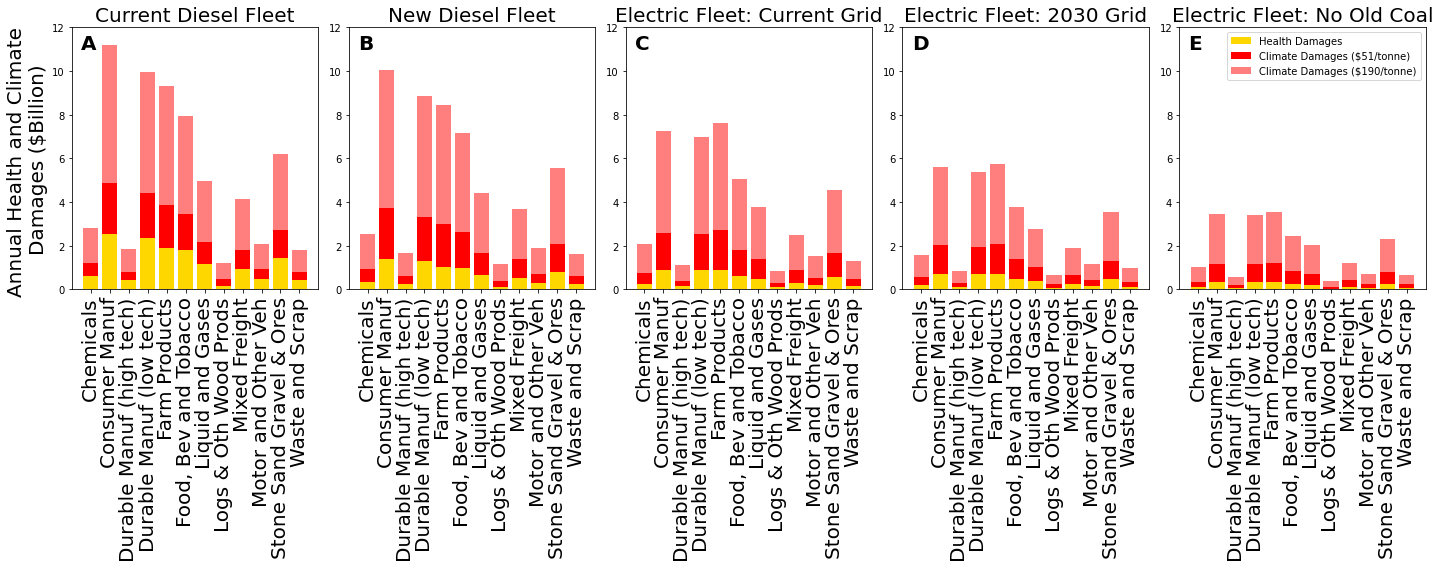

In [26]:
f, ax = plt.subplots(1,5, figsize = (20,8))
ax = ax.flatten()
max_val = 12
scenarios = ["fleet_avg","new_diesel","base","NREL_mid","1980_coal"]
for i,s in enumerate(scenarios):
    df = summary_table.loc[(summary_table.scenario==s) &
                      (summary_table.race=="All") &
                      (summary_table.income=="All") &
                       (summary_table.region=="All") &
                      (summary_table.state=="All"),["commodity","deaths_val","co2_value","co2_value_high"]].groupby("commodity").agg({"deaths_val":"sum","co2_value":"sum","co2_value_high":"sum"})
    df.index = df.index.str[4:-8]
    df = df/1e3
    ax[i].bar(df.index, df.deaths_val, label = "Health Damages", color = "gold")
    ax[i].bar(df.index, df.co2_value, label = "Climate Damages ($51/tonne)", bottom = df.deaths_val, color = "red")
    ax[i].bar(df.index, df.co2_value_high, label = "Climate Damages ($190/tonne)", bottom = df.deaths_val, color = "red", alpha = 0.5)
    ax[i].set_ylim([0,max_val])
    for tick in ax[i].get_xticklabels():
        tick.set_rotation(90)
        tick.set_fontsize(20)
ax[4].legend()
ax[0].set_ylabel("Annual Health and Climate \nDamages ($Billion)",fontsize = 20)
ax[0].set_title("Current Diesel Fleet", fontsize = 20)
ax[1].set_title("New Diesel Fleet", fontsize = 20)
ax[2].set_title("Electric Fleet: Current Grid", fontsize = 20)
ax[3].set_title("Electric Fleet: 2030 Grid", fontsize = 20)
ax[4].set_title("Electric Fleet: No Old Coal", fontsize = 20)

for i, l in enumerate(["A","B","C","D","E"]):
    ax[i].text(-0.5,11,l, weight = "bold", fontsize = 20)
f.tight_layout()   
#f.savefig("fig1_damages.pdf")

In [34]:
scen_totals = pd.DataFrame(index = ["fleet_avg","new_diesel","base","NREL_mid","1980_coal"], 
                           columns = ["deaths_val","co2_value","co2_value_high"])

In [35]:
for s in scen_totals.index:
    for x in scen_totals.columns:
        scen_totals.loc[s,x] = summary_table.loc[(summary_table.scenario==s) &
                      (summary_table.race=="All") &
                      (summary_table.income=="All") &
                       (summary_table.region=="All") &
                      (summary_table.state=="All"),x].sum()/1e3

In [36]:
scen_totals["pct_health"] = scen_totals["deaths_val"]/(scen_totals["deaths_val"]+scen_totals["co2_value"])

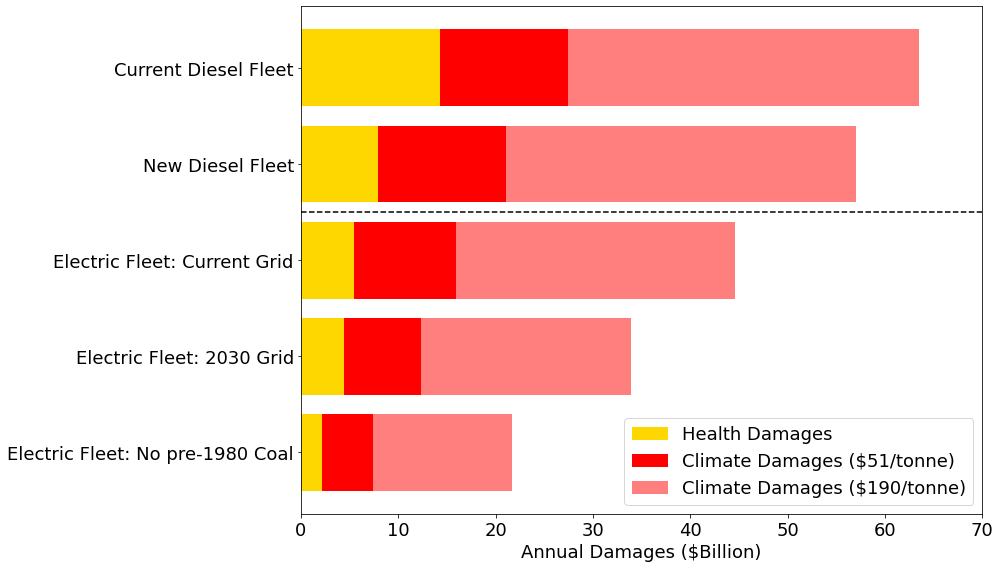

In [259]:
f, ax = plt.subplots(1,1, figsize = (14,8))
ax.barh(scen_totals.index, scen_totals.deaths_val, label = "Health Damages", color = "gold")
ax.barh(scen_totals.index, scen_totals.co2_value, label = "Climate Damages ($51/tonne)", color = "red", left = scen_totals.deaths_val)
ax.barh(scen_totals.index, scen_totals.co2_value_high, label = "Climate Damages ($190/tonne)", color = "red", left = scen_totals.deaths_val, alpha = 0.5)
ax.legend(fontsize = 18)
ax.hlines(1.5,0,70, color = "black", linestyle = "dashed")
ax.set_xlim([0,70])
plt.gca().invert_yaxis()

ax.set_yticks(np.arange(len(scen_totals)), ["Current Diesel Fleet","New Diesel Fleet","Electric Fleet: Current Grid",
                                                        "Electric Fleet: 2030 Grid", "Electric Fleet: No pre-1980 Coal"], fontsize = 18)
for tick in ax.get_xticklabels():
        tick.set_fontsize(18)
ax.set_xlabel("Annual Damages ($Billion)", fontsize = 18)
        
plt.tight_layout()
f.savefig("fig_scenario_totals2.pdf",bbox_inches = "tight")




## Map health damages

In [37]:
commodities = summary_table.commodity.unique()
deaths_dict = {}
max_val = 0
max_val_log = 0
for com in commodities:
    c = com
    deaths_dict[c] = {}
    for s in ["fleet_avg","new_diesel"]:
        c = com + " All"
        d = diesel_deaths[s][c].copy()
        d["deathsK_pc"]*=1000000
        d = d.to_crs("epsg:4269")
        deaths_dict[com][s] = d
        v = d["deathsK_pc"].max()
        if v > max_val:
            max_val = v
    for s in ["base","NREL_mid","1980_coal"]:
        c = com + " All"
        d = elec_deaths[s][c].copy()
        d = d.to_crs("epsg:4269")
        d["deathsK_pc"] = d["deathsK"]/d["Population"]
        d["deathsK_pc"]*=1000000
        deaths_dict[com][s] = d
        v = d["deathsK_pc"].max()
        if v > max_val:
            max_val = v
        
 

/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_44737/90118995.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


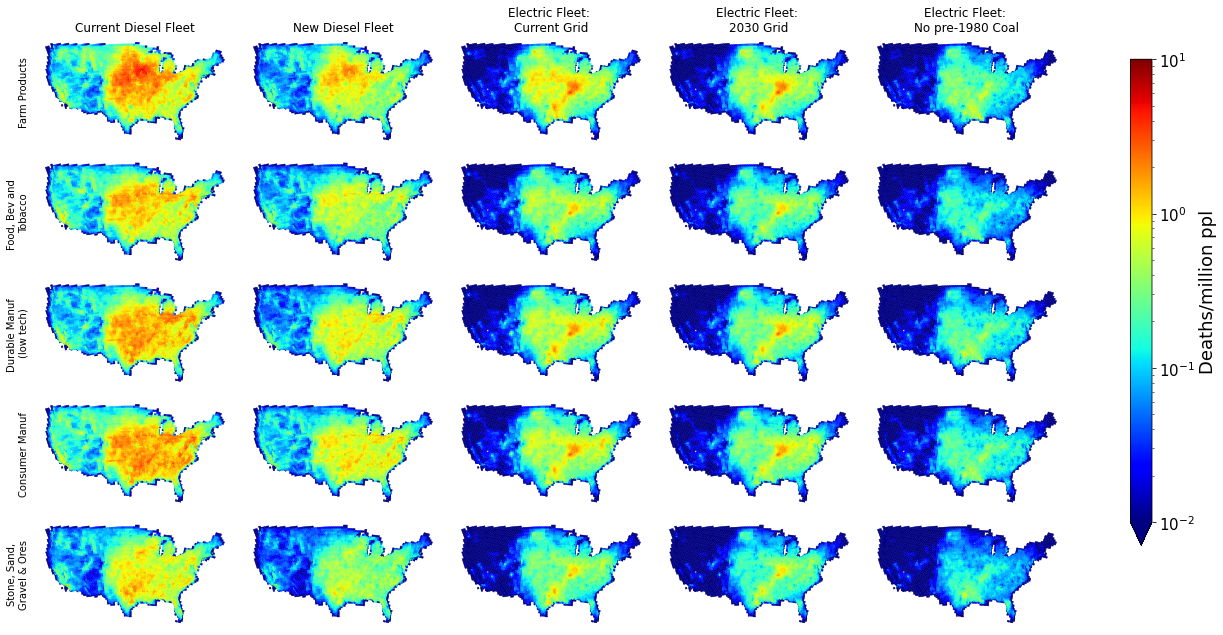

In [262]:
from matplotlib import colors
f, ax = plt.subplots(5,5, figsize = (15,9))
comms = ['TOT Farm Products-Tons_22', 'TOT Food, Bev and Tobacco-Tons_22', 'TOT Durable Manuf (low tech)-Tons_22',
        'TOT Consumer Manuf-Tons_22','TOT Stone Sand Gravel & Ores-Tons_22']
labels = ["Farm Products","Food, Bev and \nTobacco","Durable Manuf \n(low tech)","Consumer Manuf","Stone, Sand,\nGravel & Ores"]
titles = ["Current Diesel Fleet","New Diesel Fleet","Electric Fleet: \nCurrent Grid","Electric Fleet: \n2030 Grid", "Electric Fleet: \nNo pre-1980 Coal"]
for i, c in enumerate(comms):
    ax[i,0].set_ylabel(labels[i])
    for j, s in enumerate(["fleet_avg","new_diesel","base","NREL_mid","1980_coal"]):
        ax[0,j].set_title(titles[j])
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        ax[i,j].set_frame_on(False)
        deaths_dict[c][s].plot(column = "deathsK_pc", cmap = "jet", vmax = 10, ax = ax[i,j], 
                               norm = colors.LogNorm(vmin = 0.01, vmax = 10), edgecolor="face", linewidth=0.4) 
sm = plt.cm.ScalarMappable(cmap = "jet", norm = colors.LogNorm(vmin = 0.01, vmax = 10))
cax = f.add_axes([1.05, 0.15, 0.02, 0.75])
cbar = f.colorbar(sm, cax = cax, extend = "min")
cbar.ax.tick_params(labelsize = 15)
cbar.set_label("Deaths/million ppl", fontsize = 18)        
plt.tight_layout()
f.savefig("fig2_maps_log_jet2.png", bbox_inches='tight')

In [39]:
deaths_dict["All"] = {}
comms = summary_table.commodity.unique()
for s in ["fleet_avg","new_diesel","base","NREL_mid","1980_coal"]:
    deaths_dict["All"][s] = deaths_dict[comms[0]][s].copy()
    for c in comms[1:]:
        deaths_dict["All"][s]["deathsK_pc"]+=deaths_dict[c][s]["deathsK_pc"]

Text(0.5, 82.0, 'Annual Avoided Damages \n($Billion)')

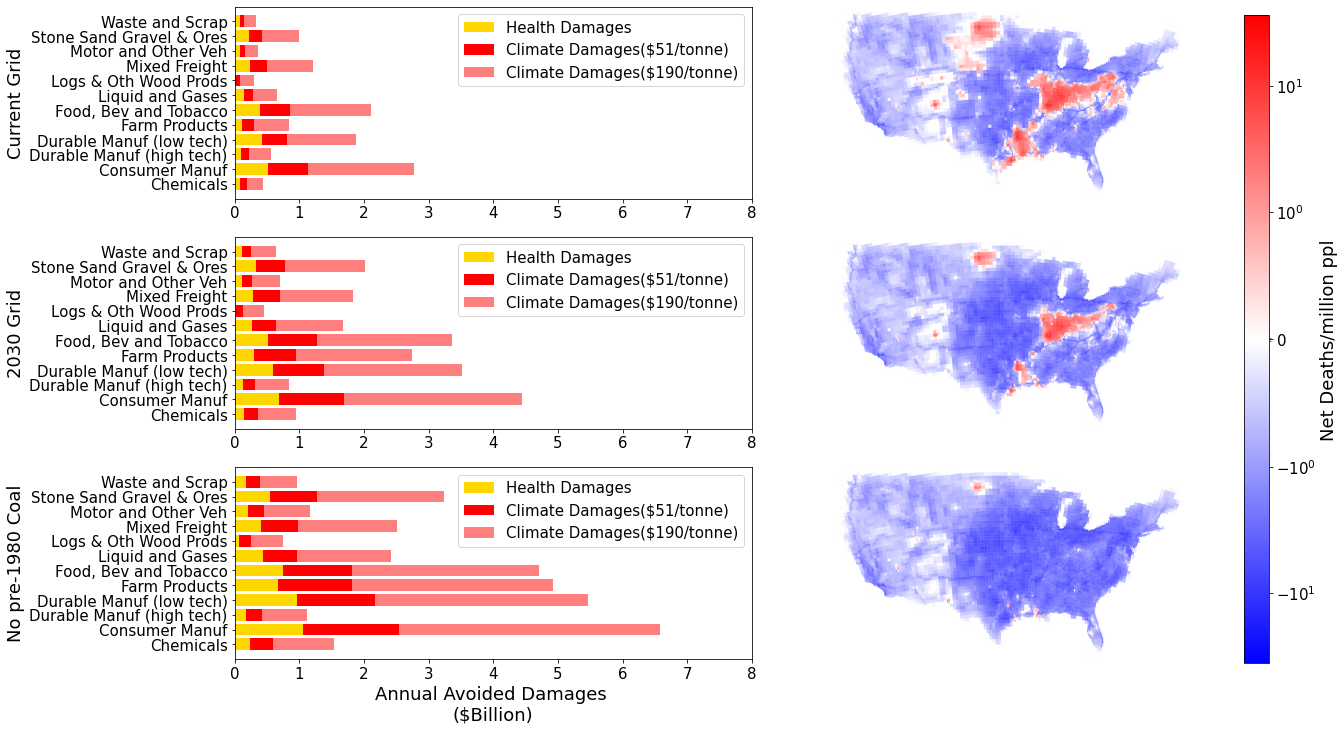

In [264]:
f, ax = plt.subplots(3, 2, figsize = (17,12), gridspec_kw={'width_ratios': [1.5, 1]})
titles = ["Current Grid","2030 Grid","No pre-1980 Coal"]
df_diesel = summary_table.loc[(summary_table.scenario=="new_diesel") &
                      (summary_table.race=="All") &
                      (summary_table.income=="All") &
                       (summary_table.region=="All") &
                      (summary_table.state=="All"),["commodity","deaths_val","co2_value","co2_value_high"]].groupby("commodity").agg({"deaths_val":"sum","co2_value":"sum","co2_value_high":"sum"})

gdf_diesel = deaths_dict["All"]["new_diesel"]

for i,s in enumerate(["base","NREL_mid","1980_coal"]):
    max_val = 8
    df_elec = summary_table.loc[(summary_table.scenario==s) &
                      (summary_table.race=="All") &
                      (summary_table.income=="All") &
                       (summary_table.region=="All") &
                      (summary_table.state=="All"),["commodity","deaths_val","co2_value","co2_value_high"]].groupby("commodity").agg({"deaths_val":"sum","co2_value":"sum","co2_value_high":"sum"})
    df_net = df_diesel.copy()
    df_net["deaths_val"] -=df_elec["deaths_val"]
    df_net["co2_value"] -=df_elec["co2_value"]
    df_net["co2_value_high"] -=df_elec["co2_value_high"]
    
    df_net.index = df_net.index.str[4:-8]
    df_net = df_net/1e3
    ax[i,0].barh(df_net.index, df_net.deaths_val, label = "Health Damages", color = "gold")
    ax[i,0].barh(df_net.index, df_net.co2_value, label = "Climate Damages($51/tonne)", left = df_net.deaths_val, color = "red")
    ax[i,0].barh(df_net.index, df_net.co2_value_high, label = "Climate Damages($190/tonne)", left = df_net.deaths_val, color = "red", alpha = 0.5)
    ax[i,0].set_xlim([0,max_val])
    ax[i,0].set_ylabel(titles[i], fontsize = 18)

    ax[i,0].legend(fontsize = 15)
    for tick in ax[i,0].get_xticklabels():
    #     tick.set_rotation(90)
        tick.set_fontsize(15)
    for tick in ax[i,0].get_yticklabels():
        tick.set_fontsize(15)
        
    
    gdf_elec = deaths_dict["All"][s]
    gdf_net = gdf_elec.copy()
    gdf_net["deathsK_pc"]-=gdf_diesel["deathsK_pc"]
    max_val = gdf_net.deathsK_pc.abs().max()
    
    gdf_net.plot(column = "deathsK_pc", cmap = "bwr", ax = ax[i,1],
                norm = colors.SymLogNorm(linthresh=0.1, linscale=0.01,
                                         vmin = -1*max_val, vmax = max_val), edgecolor="face", linewidth=0.4)
    ax[i,1].set_frame_on(False)
    ax[i,1].set_xticks([])
    ax[i,1].set_yticks([])
    ax[i,1].set_xlim([-125.2,-66.5])
    ax[i,1].set_ylim([24.4,49.7])
    
sm = plt.cm.ScalarMappable(cmap = "bwr", norm = colors.SymLogNorm(linthresh=0.1, linscale=0.01,
                                         vmin = -1*max_val, vmax = max_val))
cax = f.add_axes([0.95, 0.12, 0.02, 0.75])
cbar = f.colorbar(sm, cax = cax, ticks = [-10,-1,0,1,10])
cbar.ax.tick_params(labelsize = 15)
cbar.set_label("Net Deaths/million ppl", fontsize = 18) 
ax[2,0].set_xlabel("Annual Avoided Damages \n($Billion)", fontsize = 18)
f.savefig("fig3_net_bens2.pdf",bbox_inches = "tight")
    
#plt.tight_layout()
    

## Race and Income Effects

In [40]:
states = gpd.read_file("tl_2019_us_state/tl_2019_us_state.shp")

/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_34835/3529939156.py:10: RuntimeWarning: invalid value encountered in double_scalars
  state_deaths_pc.loc[dem, state] = df.loc[df["STATEFP"]==state,f"{dem}_deathsK"].sum()/df.loc[df["STATEFP"]==state,f"{dem}_pop"].sum()*100000
/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_34835/3529939156.py:11: RuntimeWarning: invalid value encountered in double_scalars
  totals = pd.Series({state: df.loc[df["STATEFP"]==state,"deathsK"].sum()/df.loc[df["STATEFP"]==state,"Population"].sum()*100000 for state in state_deaths_pc.columns})
/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_34835/3529939156.py:10: RuntimeWarning: invalid value encountered in double_scalars
  state_deaths_pc.loc[dem, state] = df.loc[df["STATEFP"]==state,f"{dem}_deathsK"].sum()/df.loc[df["STATEFP"]==state,f"{dem}_pop"].sum()*100000
/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_34835/3529939156.py:11: RuntimeWarning: invalid value enco

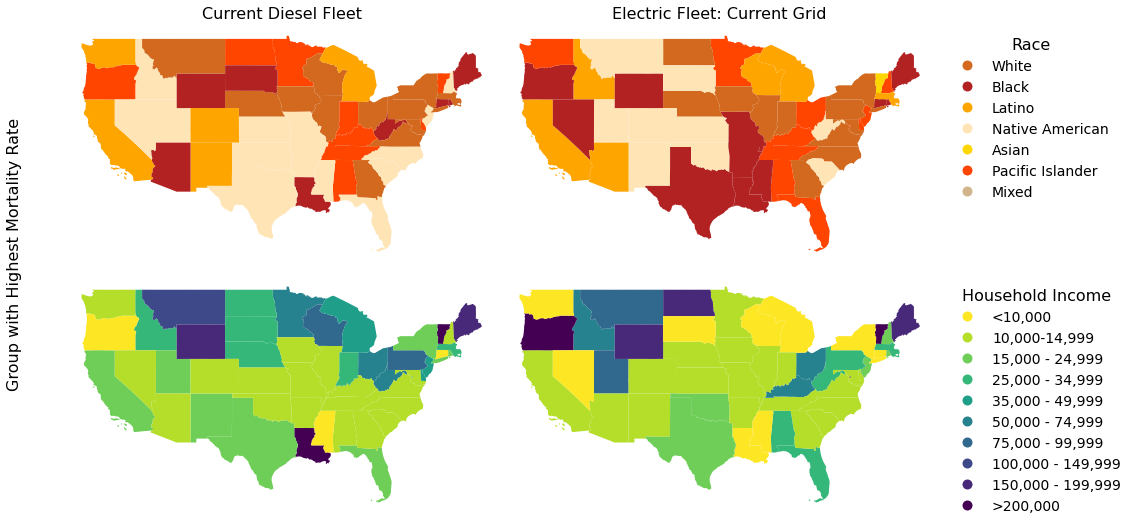

In [301]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

f, ax = plt.subplots(2,2, figsize = (15,8))
cols2 = ["chocolate","firebrick","orange","moccasin","gold","orangered","tan"]
race_colors = {"White":cols2[0],
               "Black":cols2[1],
               "Latino":cols2[2],
               "Native":cols2[3],
               "Asian":cols2[4],
               "Pac Islander":cols2[5],
               "Two or More":cols2[6]}
race_names = ["White","Black","Latino","Native American","Asian","Pacific Islander","Mixed"]

for i,s in enumerate(["fleet_avg","base"]):
    dem_df = attach_demographics(deaths_dict["All"][s], demographics)
    state_deaths_pc, state_deaths = make_state_death_tables(dem_df)
    highest_race = add_highest_race(make_state_deaths_race(state_deaths_pc))
    highest_race["race_gap"] = 0
    highest_race["avg_deaths_pc"] = 0
    for s in highest_race.index:
        highest_race.loc[s, "avg_deaths_pc"] = state_deaths_pc.loc["Totals",s]
        highest_race.loc[s,"race_gap"] = highest_race.loc[s,"max_deaths_pc"] - state_deaths_pc.loc["Totals",s]
    max_gap = highest_race.race_gap.max()
    highest_race["race_gap_n"] = highest_race["race_gap"]/max_gap
    highest_race["race_gap_pct"] = highest_race["race_gap"]/highest_race["avg_deaths_pc"]
    max_gap_pct = highest_race["race_gap_pct"].max()
    highest_race["race_gap_pct_n"] = highest_race["race_gap_pct"]/max_gap_pct
    highest_race_geo = states.merge(highest_race, left_on = "STATEFP", right_index = True)
    
    hatches = ['...','..','.','o','O']
    labels = ["<20%","20-40%","40-60%","60-80%",">80%"]
    
    h0 = mpatches.Patch( facecolor="white",alpha=0,hatch=hatches[0],label=labels[0])
    h1 = mpatches.Patch( facecolor="white",alpha=0,hatch=hatches[1],label=labels[1])
    h2 = mpatches.Patch( facecolor="white",alpha=0,hatch=hatches[2],label=labels[2])
    h3 = mpatches.Patch( facecolor="white",alpha=0,hatch=hatches[3],label=labels[3])
    h4 = mpatches.Patch( facecolor="white",alpha=0,hatch=hatches[4],label=labels[4])
    
    highest_race_geo["color"] = highest_race_geo["highest_race"].map(race_colors)
    
    highest_race_geo.plot(color = highest_race_geo["color"], ax = ax[0,i], legend = False)

    highest_income = add_highest_income(make_state_deaths_income(state_deaths_pc))
    highest_income["race_gap"] = 0
    highest_income["avg_deaths_pc"] = 0
    for s in highest_income.index:
        highest_income.loc[s, "avg_deaths_pc"] = state_deaths_pc.loc["Totals",s]
        highest_income.loc[s,"race_gap"] = highest_income.loc[s,"max_deaths_pc"] - state_deaths_pc.loc["Totals",s]
    max_gap = highest_income.race_gap.max()
    highest_income["race_gap_n"] = highest_income["race_gap"]/max_gap
    highest_income["race_gap_pct"] = highest_income["race_gap"]/highest_race["avg_deaths_pc"]
    max_gap_pct = highest_income["race_gap_pct"].max()
    highest_income["race_gap_pct_n"] = highest_income["race_gap_pct"]/max_gap_pct
    highest_income_geo = states.merge(highest_income, left_on = "STATEFP", right_index = True)
    highest_income_geo["high_inc_cat"] = pd.Categorical(highest_income_geo["highest_income"],['<10,000', '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'])
    
    highest_income_geo.plot(column = "high_inc_cat", cmap = "viridis_r", ax = ax[1,i], 
                            legend = (i == 1),legend_kwds = {"loc":"upper left","bbox_to_anchor":(1, 1),"fontsize":14,"frameon":False})
    
  
    ax[0,i].set_yticks([])
    ax[0,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1,i].set_xticks([])
    ax[0,i].set_frame_on(False)
    ax[1,i].set_frame_on(False)
    

lines = []
for col in race_colors.values():
    lines.append(mlines.Line2D([], [], color="white", marker="o", markerfacecolor=col, markersize=11))

ax[0,1].legend(lines,race_names, loc="upper left", bbox_to_anchor=[1, 1], fontsize=14, frameon=False) #list(race_colors.keys())
    
ax[0,0].set_title("Current Diesel Fleet",fontsize = 16)
ax[0,1].set_title("Electric Fleet: Current Grid", fontsize = 16)
#ax[0,0].set_ylabel("Racial Group with Highest\nPremature Mortality Rate", fontsize = 16)
#ax[1,0].set_ylabel("Income Group with Highest\nPremature Mortality Rate", fontsize = 16)
ax[0,1].get_legend().set_title("Race",prop={'size':16})
ax[1,1].get_legend().set_title("Household Income",prop={'size':16})
ax[0,0].set_aspect(ax[1,1].get_aspect())
ax[0,1].set_aspect(ax[1,1].get_aspect())
ax[1,0].set_aspect(ax[1,1].get_aspect())
f.text(-0.04, 0.55, 'Group with Highest Mortality Rate', va='center', rotation='vertical', fontsize = 16)

plt.tight_layout()
f.savefig("highest_race_no_hatch.png", bbox_inches = "tight")

## Highway Routes

In [42]:
hwy_tmiles = pd.read_csv("interstate_tmiles_22.csv")
hwy_tmiles = hwy_tmiles.set_index("Unnamed: 0")

In [43]:
deaths_t = {}
co2_t = {}
for s in ["fleet_avg", "new_diesel"]:
    deaths_t[s] = {}
    co2_t[s] = {}
    for hwy in [5,10,15,20,25,30,35,40,45,55,65,70,75,80,85,90,95]:
        with open(f"Results/diesel_deaths_{s}_I_{hwy}_TOT Tons_22 All",'rb') as f:
            deaths_t[s][hwy] = pickle.load(f)
        with open(f"Results/diesel_co2_{s}_I_{hwy}_TOT Tons_22 All",'rb') as f:
            co2_t[s][hwy] = pickle.load(f)
for s in ["base"]:
    deaths_t[s] = {}
    co2_t[s] = {}
    for hwy in [5,10,15,20,25,30,35,40,45,55,65,70,75,80,85,90,95]:
        with open(f"Results/elec_deaths_{s}_I_{hwy}_TOT Tons_22 All",'rb') as f:
            deaths_t[s][hwy] = pickle.load(f)
        with open(f"Results/elec_co2_{s}_I_{hwy}_TOT Tons_22 All",'rb') as f:
            co2_t[s][hwy] = pickle.load(f)

In [44]:
hwy_info = {}
for s in ["fleet_avg","new_diesel"]:
    hwy_info[s] = hwy_tmiles.copy()
    hwy_info[s]["deathsK"] = 0
    hwy_info[s]["co2"] = 0
    for h in [5,10,15,20,25,30,35,40,45,55,65,70,75,80,85,90,95]:
        hwy_info[s].loc[h,"deathsK"] = deaths_t[s][h]["deathsK"].sum()
        hwy_info[s].loc[h,"co2"] = co2_t[s][h]["CO2"].sum()/1e3
    
    hwy_info[s]["deaths_val"] = hwy_info[s]["deathsK"]*9.63
    hwy_info[s]["co2_val_low"] = hwy_info[s]["co2"]*51/1e6
    hwy_info[s]["co2_val_high"] = hwy_info[s]["co2"]*190/1e6
    hwy_info[s]["total_damage_low"] = hwy_info[s]["co2_val_low"]+hwy_info[s]["deaths_val"]
    hwy_info[s]["total_damage_high"] = hwy_info[s]["co2_val_high"]+hwy_info[s]["deaths_val"]
    hwy_info[s]["damage_tmile_low"] = hwy_info[s]["total_damage_low"]/hwy_info[s]["ton-miles"]*1e6 #dollars per ton-mile
    hwy_info[s]["damage_tmile_high"] = hwy_info[s]["total_damage_high"]/hwy_info[s]["ton-miles"]*1e6
for s in ["base"]:
    hwy_info[s] = hwy_tmiles.copy()
    hwy_info[s]["deathsK"] = 0
    hwy_info[s]["co2"] = 0
    for h in [5,10,15,20,25,30,35,40,45,55,65,70,75,80,85,90,95]:
        hwy_info[s].loc[h,"deathsK"] = deaths_t[s][h]["deathsK"].sum()
        hwy_info[s].loc[h,"co2"] = co2_t[s][h]
    
    hwy_info[s]["deaths_val"] = hwy_info[s]["deathsK"]*9.63
    hwy_info[s]["co2_val_low"] = hwy_info[s]["co2"]*51/1e6
    hwy_info[s]["co2_val_high"] = hwy_info[s]["co2"]*190/1e6
    hwy_info[s]["total_damage_low"] = hwy_info[s]["co2_val_low"]+hwy_info[s]["deaths_val"]
    hwy_info[s]["total_damage_high"] = hwy_info[s]["co2_val_high"]+hwy_info[s]["deaths_val"]
    hwy_info[s]["damage_tmile_low"] = hwy_info[s]["total_damage_low"]/hwy_info[s]["ton-miles"]*1e6
    hwy_info[s]["damage_tmile_high"] = hwy_info[s]["total_damage_high"]/hwy_info[s]["ton-miles"]*1e6

In [45]:
hwys_net = hwy_info["base"].copy()
hwys_net[['deathsK', 'co2', 'deaths_val', 'co2_val_low',
       'co2_val_high', 'total_damage_low', 'total_damage_high',
       'damage_tmile_low', 'damage_tmile_high']]-=hwy_info["new_diesel"][['deathsK', 'co2', 'deaths_val', 'co2_val_low',
       'co2_val_high', 'total_damage_low', 'total_damage_high',
       'damage_tmile_low', 'damage_tmile_high']]

In [46]:
hwys_net["name"] = ""
for h in [5,10,15,20,25,30,35,40,45,55,65,70,75,80,85,90,95]:
    hwys_net.loc[h,"name"] = f"I- {h}"

In [47]:
roads = gpd.read_file("tl_2019_us_primaryroads/tl_2019_us_primaryroads.shp")

In [48]:
hwys_net_geo = roads.merge(hwys_net, left_on = "FULLNAME", right_on = "name")
hwys_net_geo = hwys_net_geo.to_crs(states.crs)

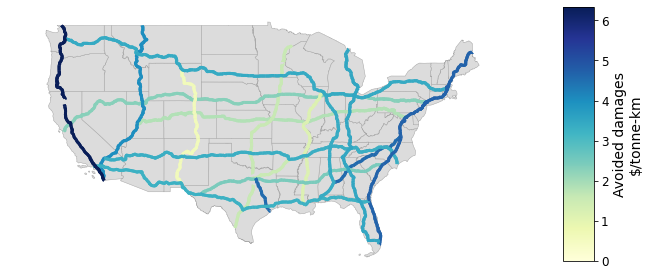

In [50]:
f, ax = plt.subplots(1,1,figsize = (10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
states.boundary.plot(ax = ax, color = "darkgray", linewidth = 0.5, facecolor = "gainsboro")
hwys_net_geo["damage_tmile_low"]*=-1
hwys_net_geo["damage_tmile_low"]*=1/1.459972
hwys_net_geo.plot(column = "damage_tmile_low", cmap = "YlGnBu", vmin = 0, legend = True, ax = ax, cax = cax, linewidth = 3)
cax.set_ylabel("Avoided damages\n$/tonne-km", fontsize = 14)
cax.tick_params(labelsize = 12)
ax.set_xlim([-130,-65])
ax.set_ylim([24,51])
plt.tight_layout()
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
#f.savefig("highways_net_damages_tot_new.pdf")

## Normalized Health and Climate Benefits

In [49]:
comm_tmiles = pd.read_csv("commodity_tmiles.csv")
comm_tmiles["Unnamed: 0"] = comm_tmiles["Unnamed: 0"]
comm_tmiles = comm_tmiles.set_index("Unnamed: 0")

In [50]:
damage_tmile = {}
for s in ["fleet_avg","new_diesel","base"]:
    damage_tmile[s] = comm_tmiles.copy()
    for c in damage_tmile[s].index:
        damage_tmile[s].loc[c,"deaths"] = summary_table.loc[(summary_table.scenario==s) &
                                                  (summary_table.race == "All") & 
                                                      (summary_table.income=="All") &
                                                      (summary_table.region=="All") &
                                                      (summary_table.commodity==c),"deaths"].sum()
        damage_tmile[s].loc[c,"co2"] = summary_table.loc[(summary_table.scenario==s) &
                                                  (summary_table.race == "All") & 
                                                      (summary_table.income=="All") &
                                                      (summary_table.region=="All") &
                                                      (summary_table.commodity==c),"co2"].sum()
        damage_tmile[s].loc[c,"deaths_val"] = summary_table.loc[(summary_table.scenario==s) &
                                                  (summary_table.race == "All") & 
                                                      (summary_table.income=="All") &
                                                      (summary_table.region=="All") &
                                                      (summary_table.commodity==c),"deaths_val"].sum()
        damage_tmile[s].loc[c,"co2_val"] = summary_table.loc[(summary_table.scenario==s) &
                                                  (summary_table.race == "All") & 
                                                      (summary_table.income=="All") &
                                                      (summary_table.region=="All") &
                                                      (summary_table.commodity==c),"co2_value"].sum()
        damage_tmile[s]["total_damages"] = damage_tmile[s]["deaths_val"]+damage_tmile[s]["co2_val"]
        damage_tmile[s]["damage_tmile"] = damage_tmile[s]["total_damages"]/damage_tmile[s]["ton-miles"]*1e6
        damage_tmile[s]["damage_tmile_health"] = damage_tmile[s]["deaths_val"]/damage_tmile[s]["ton-miles"]*1e6
        damage_tmile[s]["damage_tmile_clim"] = damage_tmile[s]["co2_val"]/damage_tmile[s]["ton-miles"]*1e6

In [51]:
net_damage_tmile = damage_tmile["base"].copy()
net_damage_tmile[["deaths","co2","deaths_val",
                  "co2_val","total_damages","damage_tmile",
                  "damage_tmile_health","damage_tmile_clim"]]-=damage_tmile["new_diesel"][["deaths","co2","deaths_val"
                                                                                           ,"co2_val","total_damages","damage_tmile",
                                                                                          "damage_tmile_health","damage_tmile_clim"]]

In [52]:
net_benefit_tmile = net_damage_tmile.copy().abs()
net_benefit_tmile["commodity"] = net_benefit_tmile.index.str[4:-8]

In [53]:
comm_vals = pd.read_csv("commodity_values_22_all.csv")
comm_vals["commodity"] = comm_vals["commodity"].str[4:]

In [54]:
net_benefit_tmile["comm_val"] = 0
for c in net_benefit_tmile.index:
    comm = c[4:-8]
    net_benefit_tmile.loc[c,"comm_val"] = comm_vals.loc[comm_vals.commodity==comm,"million dollars in 2022"].sum()
net_benefit_tmile["damage_val"] = net_benefit_tmile["total_damages"]/net_benefit_tmile["comm_val"]*1e3 #dollars saved per 1000 dollars of commodity shipped

In [55]:
net_benefit_tmile = net_benefit_tmile.drop(net_benefit_tmile.index[-1])

In [56]:
faf = pd.read_csv("FAF_22_output.csv") #Note that this includes Alaska, others we removed

In [57]:
faf["category"] = ""
faf.loc[faf.sctg2.isin(['01-Live animals/fish', '02-Cereal grains', '03-Other ag prods.',
       '04-Animal feed', '05-Meat/seafood']),"category"] = "Farm Products"
faf.loc[faf.sctg2.isin(['06-Milled grain prods.',
       '07-Other foodstuffs', '08-Alcoholic beverages',
       '09-Tobacco prods.']),"category"] = "Food, Bev and Tobacco"
faf.loc[faf.sctg2.isin(['10-Building stone', '11-Natural sands',
       '12-Gravel', '13-Nonmetallic minerals', '14-Metallic ores',
       '15-Coal']),"category"] = "Stone Sand Gravel & Ores"
faf.loc[faf.sctg2.isin(['16-Crude petroleum', '17-Gasoline', '18-Fuel oils',
       '19-Coal-n.e.c.']),"category"] = "Liquid and Gases"
faf.loc[faf.sctg2.isin(['20-Basic chemicals', '21-Pharmaceuticals',
       '22-Fertilizers']),"category"] = "Chemicals"
faf.loc[faf.sctg2.isin(['25-Logs']),"category"] = "Logs & Oth Wood Prods"
faf.loc[faf.sctg2.isin(['41-Waste/scrap']),"category"] = "Waste and Scrap"
faf.loc[faf.sctg2.isin(['23-Chemical prods.', '24-Plastics/rubber','26-Wood prods.', '27-Newsprint/paper',
       '28-Paper articles', '29-Printed prods.', '30-Textiles/leather']),"category"] = "Consumer Manuf"
faf.loc[faf.sctg2.isin(['31-Nonmetal min. prods.', '32-Base metals',
       '33-Articles-base metal', '34-Machinery','39-Furniture']),"category"] = "Durable Manuf (low tech)"
faf.loc[faf.sctg2.isin(['35-Electronics','37-Transport equip.',
       '38-Precision instruments']),"category"] = "Durable Manuf (high tech)"
faf.loc[faf.sctg2.isin(['36-Motorized vehicles']),"category"] = "Motor and Other Veh"
faf.loc[faf.sctg2.isin(['40-Misc. mfg. prods.','43-Mixed freight']),"category"] = "Mixed Freight"



In [58]:
faf_com = faf.groupby("category").agg({"million ton-miles in 2022":"sum","thousand tons in 2022":"sum"})

In [59]:
faf_com["miles_ton"] =faf_com["million ton-miles in 2022"]*1e6/(faf_com["thousand tons in 2022"]*1e3)

In [60]:
net_benefit_tmile["miles_ton"] = 0
for c in net_benefit_tmile.index:
    comm = c[4:-8]
    net_benefit_tmile.loc[c,"miles_ton"] = faf_com.loc[comm,"miles_ton"]

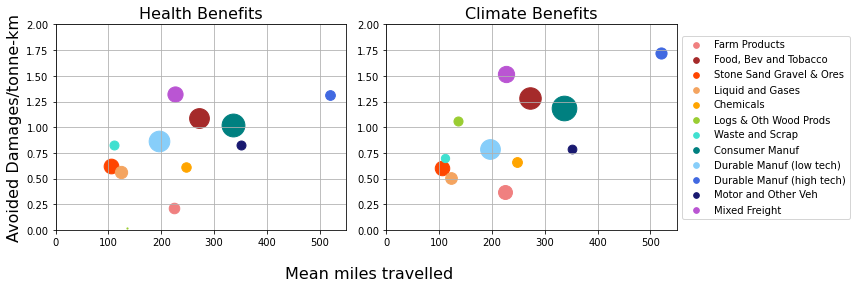

In [219]:

cols = ["yellow","yellowgreen","limegreen","mediumseagreen","darkgreen",
        "aquamarine","darkturquoise","cornflowerblue","blue","midnightblue", "mediumpurple","mediumorchid","red"]

cols = ["lightcoral","brown","orangered","sandybrown","orange","yellowgreen",
        "turquoise","teal","lightskyblue","royalblue","midnightblue","mediumorchid"]
inc_colors = {'Farm Products': cols[0], 
              'Food, Bev and Tobacco': cols[1],
       'Stone Sand Gravel & Ores': cols[2], 
              'Liquid and Gases': cols[3], 
              'Chemicals': cols[4],
       'Logs & Oth Wood Prods': cols[5], 
              'Waste and Scrap': cols[6], 
              'Consumer Manuf': cols[7],
       'Durable Manuf (low tech)': cols[8], 
              'Durable Manuf (high tech)': cols[9],
       'Motor and Other Veh': cols[10], 
              'Mixed Freight': cols[11]}


f, ax = plt.subplots(1,2,figsize = (12,4))
ax = ax.flatten()

for c in net_benefit_tmile.index:
    ax[0].scatter(x = net_benefit_tmile.loc[c,"miles_ton"],
              y = net_benefit_tmile.loc[c,"damage_tmile_health"]/1.459972,
              s = net_benefit_tmile.loc[c,"deaths_val"]*1,
              c = inc_colors[c[4:-8]],
              label = net_benefit_tmile.loc[c,"commodity"])

ax[0].set_xlim([0,550])
ax[0].set_ylim([0,2])
ax[0].grid()
ax[0].set_ylabel("Avoided Damages/tonne-km", fontsize = 16)
ax[0].set_title("Health Benefits", fontsize = 16)
ax[1].set_title("Climate Benefits", fontsize = 16)

f.supxlabel('Mean miles travelled                       ', fontsize = 16, ha = 'center')



for c in net_benefit_tmile.index:
    ax[1].scatter(x = net_benefit_tmile.loc[c,"miles_ton"],
              y = net_benefit_tmile.loc[c,"damage_tmile_clim"]/1.459972,
              s = net_benefit_tmile.loc[c,"co2_val"]*1,
              c = inc_colors[c[4:-8]],
              label = net_benefit_tmile.loc[c,"commodity"])
leg = ax[1].legend(bbox_to_anchor = [1,0.5], loc = "center left")
for h in leg.legendHandles:
    h.set_sizes([32])
ax[1].set_xlim([0,550])
ax[1].set_ylim([0,2])
ax[1].grid()
plt.tight_layout()
f.savefig("fig_benefits_tmile2.pdf", bbox_inches = "tight")

## Race and income-specific benefits

In [61]:
benefits_race_pc = pd.DataFrame(index = ["White_pct","Black_pct","Latino_pct","Native_pct","Asian_pct","Pac Islander_pct","Two or More_pct"],
                            columns = summary_table.commodity.unique())

for r in benefits_race_pc.index:
    for c in benefits_race_pc.columns:
        benefits_race_pc.loc[r,c] = (summary_table.loc[(summary_table.scenario=="base") &
                                              (summary_table.commodity==c) &
                                              (summary_table.race==r)&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All") & 
                                            (summary_table.income=="All"),"deaths_pc"].sum() -
                                 summary_table.loc[(summary_table.scenario=="new_diesel") &
                                              (summary_table.commodity==c) &
                                              (summary_table.race==r)&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All") & 
                                            (summary_table.income=="All"),"deaths_pc"].sum())*-1*9.63*1e6/1e5 #this is dollars saved per 100,000 ppl?

In [62]:
benefits_income_pc = pd.DataFrame(index = ['<10,000',
       '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'],
                            columns = summary_table.commodity.unique())

for i in benefits_income_pc.index:
    for c in benefits_income_pc.columns:
        benefits_income_pc.loc[i,c] = (summary_table.loc[(summary_table.scenario=="base") &
                                              (summary_table.commodity==c) &
                                              (summary_table.race=="All")&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All") & 
                                                         (summary_table.income == i),"deaths_pc"].sum() -
                                 summary_table.loc[(summary_table.scenario=="new_diesel") &
                                              (summary_table.commodity==c) &
                                              (summary_table.race=="All")&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All")& 
                                                         (summary_table.income == i),"deaths_pc"].sum())*-1*9.63*1e6/1e5 #this is dollars saved per 100,000 ppl?

In [63]:
benefits_race = pd.DataFrame(index = ["White_pct","Black_pct","Latino_pct","Native_pct","Asian_pct","Pac Islander_pct","Two or More_pct"],
                            columns = summary_table.commodity.unique())
for r in benefits_race.index:
    for c in benefits_race.columns:
        benefits_race.loc[r,c] = (summary_table.loc[(summary_table.scenario=="base") &
                                              (summary_table.commodity==c) &
                                              (summary_table.race==r)&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All"),"deaths_val"].sum() -
                                 summary_table.loc[(summary_table.scenario=="new_diesel") &
                                              (summary_table.commodity==c) &
                                              (summary_table.race==r)&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All"),"deaths_val"].sum())*1e6 #this is dollars saved

In [220]:
benefits_race_tmile= benefits_race_pc.copy()
for c in benefits_race_tmile:
    benefits_race_tmile.loc[:,c] = benefits_race_tmile.loc[:,c]/net_benefit_tmile.loc[c,"ton-miles"]*1e9/1.459972 #this is $/c in benefits per billion ton-miles shipped conver to tonne-km
    
benefits_race_tmile.index = ["White","Black","Latino","Native American","Asian","Pacific Islander","Mixed"]
benefits_race_tmile.columns = benefits_race_tmile.columns.str[4:-8]

In [221]:
benefits_income_tmile= benefits_income_pc.copy()
for c in benefits_income_tmile:
    benefits_income_tmile.loc[:,c] = benefits_income_tmile.loc[:,c]/net_benefit_tmile.loc[c,"ton-miles"]*1e9/1.459972 #this is $/c in benefits per billion ton-miles shipped convert to tonne-km
    
benefits_income_tmile.columns = benefits_income_tmile.columns.str[4:-8]

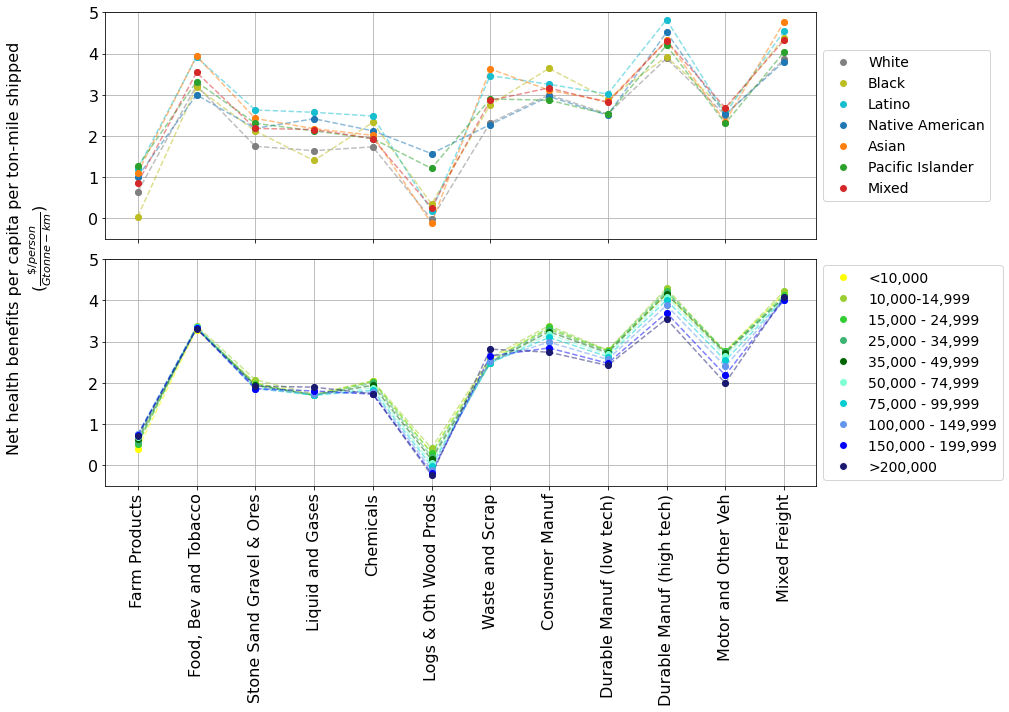

In [228]:
from matplotlib import lines as mlines

f, ax = plt.subplots(2,1,figsize = (13,10))
ax = ax.flatten()

cols = ["C7","C8","C9","C10","C11","C12","C13"]

benefits_race_tmile.T.plot(marker = 'o', ax = ax[0], linestyle = "--", alpha = 0.5, legend = False, color = cols)
benefits_race_tmile.T.plot(marker = 'o', ax = ax[0], linestyle = "", color = cols)

lines = []
for col in cols:
    lines.append(mlines.Line2D([], [], color="white", marker="o", markerfacecolor=col, markersize=8))

ax[0].legend(lines, benefits_race_tmile.index, loc="center left", bbox_to_anchor=[1,0.5], fontsize=14)

ax[0].set_xticklabels([])

#ax[0].set_ylabel("Net health benefits per capita per ton-mile shipped\n" +r"($\frac{\$/person}{Gton-miles}$)", fontsize = 16)
f.text(x = -0.05, y = 0.65, s = "Net health benefits per capita per ton-mile shipped\n" +r"($\frac{\$/person}{Gtonne-km}$)", va='center', ha = 'center',rotation='vertical', fontsize = 16)
ax[0].grid()


cols = ["yellow","yellowgreen","limegreen","mediumseagreen","darkgreen","aquamarine","darkturquoise","cornflowerblue","blue","midnightblue"]
    
benefits_income_tmile.T.plot(marker = 'o', ax = ax[1], linestyle = "--", alpha = 0.5, legend = False, color = cols)
benefits_income_tmile.T.plot(marker = 'o', ax = ax[1], linestyle = "", color = cols)

lines = []
for col in cols:
    lines.append(mlines.Line2D([], [], color="white", marker="o", markerfacecolor=col, markersize=8))

ax[1].legend(lines, benefits_income_tmile.index, loc="center left", bbox_to_anchor=[1,0.5], fontsize=14)

    
ax[1].set_xticks(np.arange(len(benefits_race_tmile.T)), benefits_race_tmile.T.index)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(90)
    tick.set_fontsize(16)
for tick in ax[0].get_yticklabels():
    tick.set_fontsize(16)
for tick in ax[1].get_yticklabels():
    tick.set_fontsize(16)
ax[1].grid()
ax[0].set_ylim([-0.5,5])
ax[1].set_ylim([-0.5,5])

plt.tight_layout()
f.savefig("fig_net_bens_race_comm2.pdf",bbox_inches = "tight")

## Race and income impacts by scenario

In [67]:
race_deaths_pc_tot = pd.DataFrame(index = ["White_pct","Black_pct","Latino_pct","Native_pct","Asian_pct","Pac Islander_pct","Two or More_pct"], 
                                  columns = ["fleet_avg","new_diesel","base","NREL_mid","1980_coal"])

for r in race_deaths_pc_tot.index:
    for s in race_deaths_pc_tot.columns:
        race_deaths_pc_tot.loc[r,s] = summary_table.loc[(summary_table.scenario==s) &
                                              (summary_table.race==r)&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All") & 
                                            (summary_table.income=="All"),"deaths_pc"].sum()
    
    


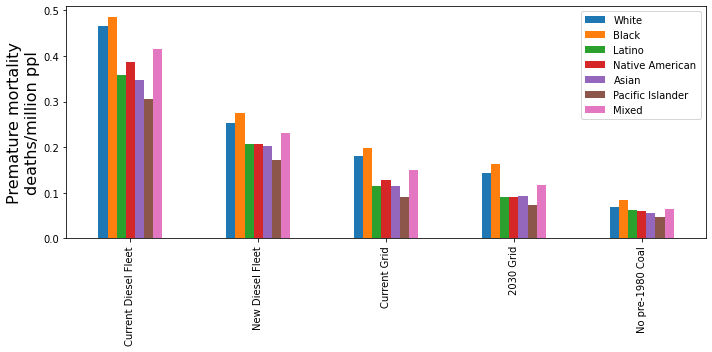

In [268]:
f, ax = plt.subplots(1,1,figsize = (10,5))
race_deaths_pc_tot.index = ["White","Black","Latino","Native American","Asian","Pacific Islander","Mixed"]
race_deaths_pc_tot.T.plot.bar(ax = ax)
ax.set_ylabel("Premature mortality\ndeaths/million ppl", fontsize = 16)
ax.set_xticks(np.arange(len(race_deaths_pc_tot.T)),["Current Diesel Fleet","New Diesel Fleet","Current Grid","2030 Grid","No pre-1980 Coal"])
plt.tight_layout()
f.savefig("race_deaths_pc_bar2.png", bbox_inches = "tight")

In [68]:
income_deaths_pc_tot = pd.DataFrame(index = ['<10,000',
       '10,000-14,999', '15,000 - 24,999', '25,000 - 34,999',
       '35,000 - 49,999', '50,000 - 74,999', '75,000 - 99,999',
       '100,000 - 149,999', '150,000 - 199,999', '>200,000'], 
                                  columns = ["fleet_avg","new_diesel","base","NREL_mid","1980_coal"])

for i in income_deaths_pc_tot.index:
    for s in income_deaths_pc_tot.columns:
        income_deaths_pc_tot.loc[i,s] = summary_table.loc[(summary_table.scenario==s) &
                                              (summary_table.race=="All")&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All") & 
                                            (summary_table.income==i),"deaths_pc"].sum()
    

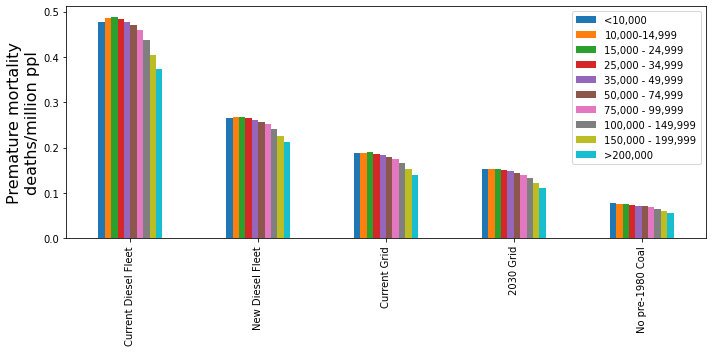

In [267]:
f, ax = plt.subplots(1,1,figsize = (10,5))

income_deaths_pc_tot.T.plot.bar(ax = ax)
ax.set_ylabel("Premature mortality\ndeaths/million ppl", fontsize = 16)
ax.set_xticks(np.arange(len(income_deaths_pc_tot.T)),["Current Diesel Fleet","New Diesel Fleet","Current Grid","2030 Grid","No pre-1980 Coal"])
plt.tight_layout()
f.savefig("income_deaths_pc_bar2.png", bbox_inches = "tight")

In [69]:
fleet_avg_pc = summary_table.loc[(summary_table.scenario=="fleet_avg") &
                                              (summary_table.race=="All")&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All") & 
                                            (summary_table.income=="All"),"deaths_pc"].sum()

base_avg_pc = summary_table.loc[(summary_table.scenario=="base") &
                                              (summary_table.race=="All")&
                                              (summary_table.region=="All")&
                                              (summary_table.state=="All") & 
                                            (summary_table.income=="All"),"deaths_pc"].sum()

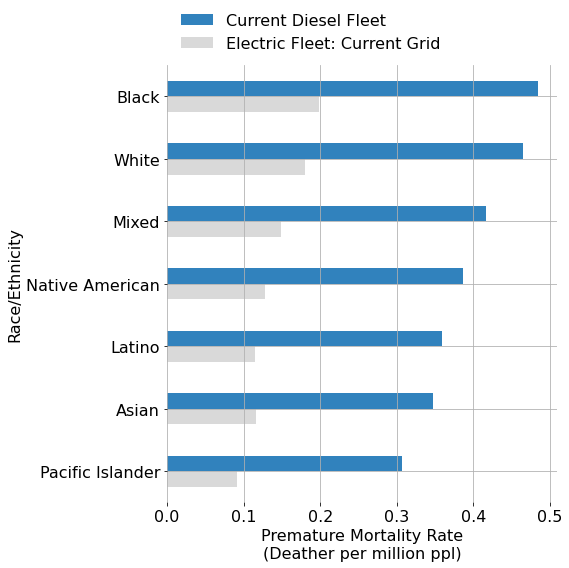

In [188]:
f, ax = plt.subplots(1,1, figsize = (8,8))
race_deaths_pc_tot.reindex(["Black_pct","White_pct","Two or More_pct","Native_pct",
                           "Latino_pct","Asian_pct","Pac Islander_pct"])[["fleet_avg","base"]].plot.barh(ax = ax, cmap = "tab20c")
plt.gca().invert_yaxis()

ax.set_yticks(np.arange(len(race_deaths_pc_tot.index)),["Black","White","Mixed","Native American","Latino","Asian","Pacific Islander"], fontsize =16)

for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
ax.set_xlabel("Premature Mortality Rate\n(Deather per million ppl)", fontsize = 16)
# ax.vlines(fleet_avg_pc, -0.5 , 7.5, linestyle = "dashed")
# ax.vlines(base_avg_pc, -0.5 , 7.5, linestyle = "dashed")  
ax.legend(labels = ["Current Diesel Fleet","Electric Fleet: Current Grid"], 
          fontsize = 16, loc = "lower left", bbox_to_anchor = (0,1), frameon = False)
ax.grid()
ax.set_frame_on(False)
ax.set_ylabel("Race/Ethnicity", fontsize = 16)
plt.tight_layout()
f.savefig("race_deaths_pc.png", bbox_inches = "tight")

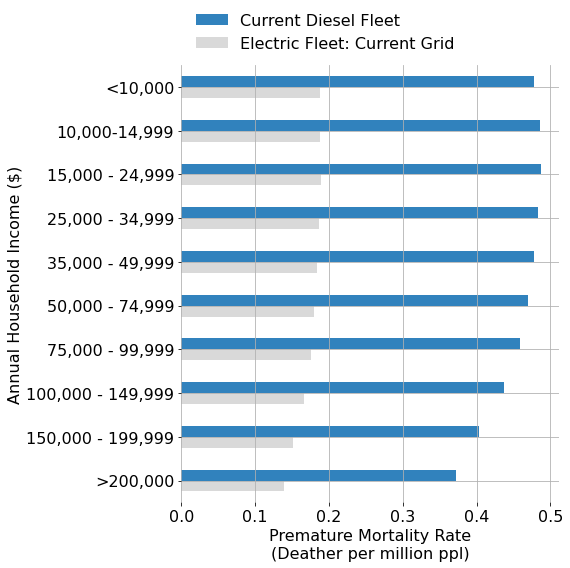

In [189]:
f, ax = plt.subplots(1,1, figsize = (8,8))
income_deaths_pc_tot[["fleet_avg","base"]].plot.barh(ax = ax, cmap = "tab20c")
plt.gca().invert_yaxis()

#ax.set_yticks(np.arange(len(race_deaths_pc_tot.index)),["Black","White","Mixed","Native American","Latino","Asian","Pacific Islander"], fontsize =16)

for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
ax.set_xlabel("Premature Mortality Rate\n(Deather per million ppl)", fontsize = 16)
# ax.vlines(fleet_avg_pc, -0.5 , 9.5, linestyle = "dashed")
# ax.vlines(base_avg_pc, -0.5 , 9.5, linestyle = "dashed")  
ax.legend(labels = ["Current Diesel Fleet","Electric Fleet: Current Grid"], 
          fontsize = 16, loc = "lower left", bbox_to_anchor = (0,1), frameon = False)
ax.set_frame_on(False)
ax.grid()
ax.set_ylabel("Annual Household Income ($)", fontsize = 16)
plt.tight_layout()
f.savefig("income_deaths_pc.png")

In [72]:
for c in summary_table.commodity.unique():
    for s in ["fleet_avg","new_diesel","base","NREL_mid","1980_coal"]:
        TotalPM25 = deaths_dict[c][s]["TotalPM25"]
        TotalPop = deaths_dict[c][s]["Population"]
        MortalityRate = deaths_dict[c][s]["Mortality"]
        deaths_dict[c][s]["deathsL"] = (np.exp(np.log(1.14)/10 * TotalPM25) - 1) * TotalPop * MortalityRate / 100000
        deaths_dict[c][s]["deathsL_pc"] = deaths_dict[c][s]["deathsL"]/deaths_dict[c][s]["Population"]
        deaths_dict[c][s]["deathsL_lb"] = (np.exp(np.log(1.07)/10 * TotalPM25) - 1) * TotalPop * MortalityRate / 100000
        deaths_dict[c][s]["deathsL_pc_lb"] = deaths_dict[c][s]["deathsL_lb"]/deaths_dict[c][s]["Population"]
        deaths_dict[c][s]["deathsL_ub"] = (np.exp(np.log(1.22)/10 * TotalPM25) - 1) * TotalPop * MortalityRate / 100000
        deaths_dict[c][s]["deathsL_pc_ub"] = deaths_dict[c][s]["deathsL_ub"]/deaths_dict[c][s]["Population"]
        deaths_dict[c][s]["deathsK_lb"] = (np.exp(np.log(1.024)/10 * TotalPM25) - 1) * TotalPop * MortalityRate / 100000
        deaths_dict[c][s]["deathsK_pc_lb"] = deaths_dict[c][s]["deathsK_lb"]/deaths_dict[c][s]["Population"]
        deaths_dict[c][s]["deathsK_ub"] = (np.exp(np.log(1.097)/10 * TotalPM25) - 1) * TotalPop * MortalityRate / 100000
        deaths_dict[c][s]["deathsK_pc_ub"] = deaths_dict[c][s]["deathsK_ub"]/deaths_dict[c][s]["Population"]

## Sensitivity on health damages

In [73]:
deaths_sensitivity = pd.DataFrame(index = summary_table.commodity.unique(), columns = ["deathsK_lb",
                                                                                     "deathsK",
                                                                                     "deathsK_ub",
                                                                                     "deathsL_lb",
                                                                                     "deathsL",
                                                                                     "deathsL_ub"])

In [74]:
for i in deaths_sensitivity.index:
    for c in deaths_sensitivity.columns:
        deaths_sensitivity.loc[i,c] = deaths_dict[i]["fleet_avg"][c].sum()


In [75]:
deaths_sensitivity["deathsL_diff"] = deaths_sensitivity["deathsL"] - deaths_sensitivity["deathsK"]

In [76]:
deaths_sensitivity = deaths_sensitivity.sort_values(by = "deathsK")

In [77]:
deaths_sensitivity_base = pd.DataFrame(index = summary_table.commodity.unique(), columns = ["deathsK_lb",
                                                                                     "deathsK",
                                                                                     "deathsK_ub",
                                                                                     "deathsL_lb",
                                                                                     "deathsL",
                                                                                     "deathsL_ub"])
for i in deaths_sensitivity_base.index:
    for c in deaths_sensitivity_base.columns:
        deaths_sensitivity_base.loc[i,c] = deaths_dict[i]["base"][c].sum()
deaths_sensitivity_base["deathsL_diff"] = deaths_sensitivity_base["deathsL"] - deaths_sensitivity_base["deathsK"]
deaths_sensitivity_base = deaths_sensitivity_base.sort_values(by = "deathsK")

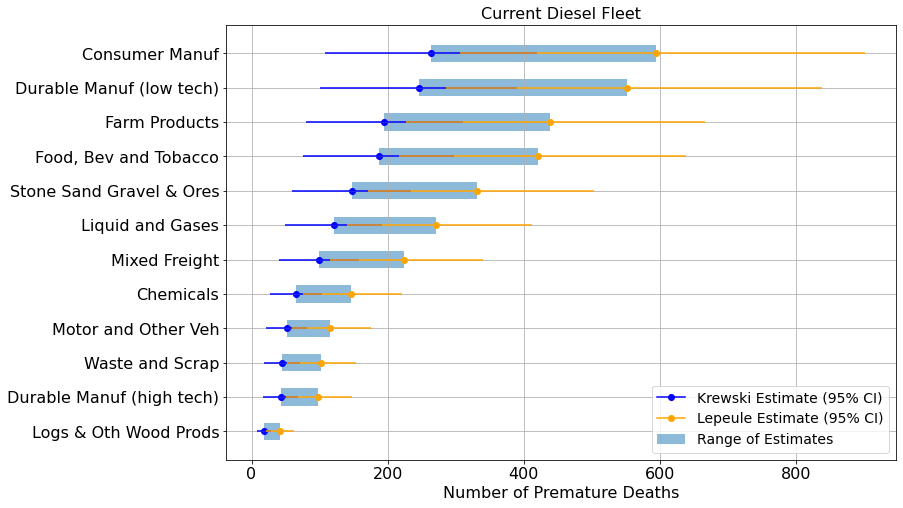

In [269]:
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

f, ax = plt.subplots(1,1, figsize = (12,8))
ax.barh(deaths_sensitivity.index, deaths_sensitivity.deathsL_diff, left = deaths_sensitivity.deathsK, 
        alpha = 0.5, height = 0.5, capstyle = "round")
#ax.set_xlim([0,600])

ax.hlines(deaths_sensitivity.index,deaths_sensitivity.deathsK_lb, deaths_sensitivity.deathsK_ub,color = "blue")
ax.hlines(deaths_sensitivity.index,deaths_sensitivity.deathsL_lb, deaths_sensitivity.deathsL_ub,color = "orange")
ax.grid()
ax.set_xlabel("Number of Premature Deaths", fontsize = 16)
ax.scatter(deaths_sensitivity.deathsK, deaths_sensitivity.index, color = "blue")
ax.scatter(deaths_sensitivity.deathsL, deaths_sensitivity.index, color = "orange")
ax.set_yticks(np.arange(len(deaths_sensitivity.index)),deaths_sensitivity.index.str[4:-8])
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
for tick in ax.get_xticklabels():
    tick.set_fontsize(16)
ax.set_title("Current Diesel Fleet", fontsize = 16)

h0 = mlines.Line2D([], [], marker="o", markerfacecolor="blue", markersize=6, color="blue")
h1 = mlines.Line2D([], [], marker="o", markerfacecolor="orange", markersize=6, color="orange")
h2 = mpatches.Rectangle((0, 0), 1, 1, alpha = 0.5)

ax.legend([h0, h1, h2], ["Krewski Estimate (95% CI)", "Lepeule Estimate (95% CI)", "Range of Estimates"], fontsize=14, loc = "lower right")

f.savefig("fig:deaths_sensitivity2.pdf", bbox_inches = "tight")

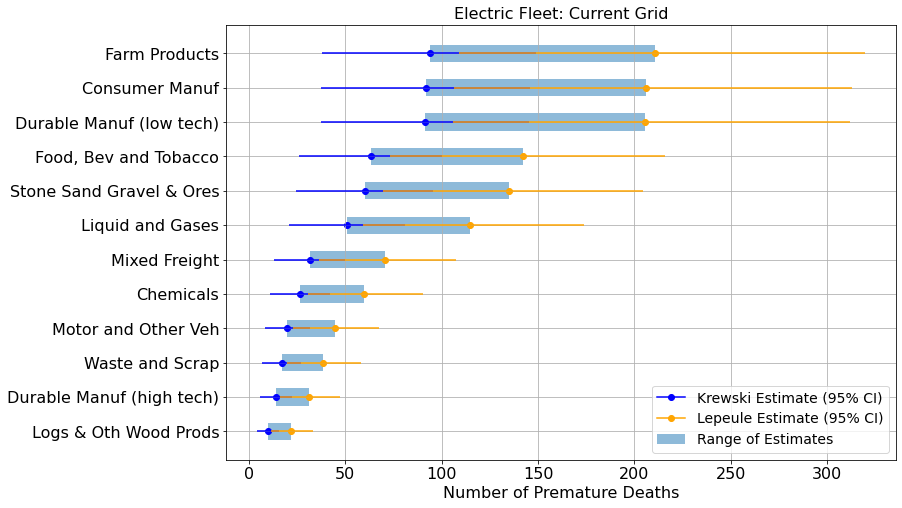

In [270]:
f, ax = plt.subplots(1,1, figsize = (12,8))
ax.barh(deaths_sensitivity_base.index, deaths_sensitivity_base.deathsL_diff, left = deaths_sensitivity_base.deathsK, 
        alpha = 0.5, height = 0.5, capstyle = "round")
#ax.set_xlim([0,600])

ax.hlines(deaths_sensitivity_base.index,deaths_sensitivity_base.deathsK_lb, deaths_sensitivity_base.deathsK_ub,color = "blue")
ax.hlines(deaths_sensitivity_base.index,deaths_sensitivity_base.deathsL_lb, deaths_sensitivity_base.deathsL_ub,color = "orange")
ax.grid()
ax.set_xlabel("Number of Premature Deaths", fontsize = 16)
ax.scatter(deaths_sensitivity_base.deathsK, deaths_sensitivity_base.index, color = "blue")
ax.scatter(deaths_sensitivity_base.deathsL, deaths_sensitivity_base.index, color = "orange")
ax.set_yticks(np.arange(len(deaths_sensitivity_base.index)),deaths_sensitivity_base.index.str[4:-8])
for tick in ax.get_yticklabels():
    tick.set_fontsize(16)
ax.set_title("Electric Fleet: Current Grid", fontsize = 16)

for tick in ax.get_xticklabels():
    tick.set_fontsize(16)

h0 = mlines.Line2D([], [], marker="o", markerfacecolor="blue", markersize=6, color="blue")
h1 = mlines.Line2D([], [], marker="o", markerfacecolor="orange", markersize=6, color="orange")
h2 = mpatches.Rectangle((0, 0), 1, 1, alpha = 0.5)

ax.legend([h0, h1, h2], ["Krewski Estimate (95% CI)", "Lepeule Estimate (95% CI)", "Range of Estimates"], fontsize=14, loc = "lower right")

f.savefig("fig:deaths_sensitivity_base2.pdf", bbox_inches = "tight")

## Summary figure

In [229]:
race_gap_benefits = pd.DataFrame(index = summary_table.commodity.unique(),
                                 columns = ["race_gap","race_gap_ratio","income_gap","income_gap_ratio"])
for c in race_gap_benefits.index:
    max_deaths_d = summary_table.loc[(summary_table.scenario=="new_diesel") &
                 (summary_table.race.isin(["White_pct","Black_pct","Native_pct","Asian_pct","Pac Islander_pct","Two or More_pct"])) &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].max()
    min_deaths_d = summary_table.loc[(summary_table.scenario=="new_diesel") &
                 (summary_table.race.isin(["White_pct","Black_pct","Native_pct","Asian_pct","Pac Islander_pct","Two or More_pct"])) &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].min()
    avg_deaths_d = summary_table.loc[(summary_table.scenario=="new_diesel") &
                 (summary_table.race=="All") &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].sum()
    max_deaths_e = summary_table.loc[(summary_table.scenario=="base") &
                 (summary_table.race.isin(["White_pct","Black_pct","Native_pct","Asian_pct","Pac Islander_pct","Two or More_pct"])) &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].max()
    min_deaths_e = summary_table.loc[(summary_table.scenario=="base") &
                 (summary_table.race.isin(["White_pct","Black_pct","Native_pct","Asian_pct","Pac Islander_pct","Two or More_pct"])) &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].min()
    avg_deaths_e = summary_table.loc[(summary_table.scenario=="base") &
                 (summary_table.race=="All") &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].sum()
    deaths_diff_d = max_deaths_d - avg_deaths_d
    deaths_diff_e = max_deaths_e - avg_deaths_e
    deaths_ratio_d = 1 - (max_deaths_d / avg_deaths_d)*100
    deaths_ratio_e = 1 - (max_deaths_e / avg_deaths_e)*100
    race_gap = deaths_diff_d - deaths_diff_e
    race_gap_ratio = deaths_ratio_d - deaths_ratio_e
    
    race_gap_benefits.loc[c,"race_gap"] = race_gap*9.63e9/1e5
    race_gap_benefits.loc[c,"race_gap_ratio"] = race_gap_ratio
    
    
    max_deaths_d = summary_table.loc[(summary_table.scenario=="new_diesel") &
                 (summary_table.race=="All") &
                 (summary_table.income.isin(incomes)) &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].max()
    min_deaths_d = summary_table.loc[(summary_table.scenario=="new_diesel") &
                 (summary_table.race=="All") &
                 (summary_table.income.isin(incomes)) &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].min()
    avg_deaths_d = summary_table.loc[(summary_table.scenario=="new_diesel") &
                 (summary_table.race=="All") &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].sum()
    max_deaths_e = summary_table.loc[(summary_table.scenario=="base") &
                 (summary_table.race=="All") &
                 (summary_table.income.isin(incomes)) &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].max()
    min_deaths_e = summary_table.loc[(summary_table.scenario=="base") &
                 (summary_table.race=="All") &
                 (summary_table.income.isin(incomes)) &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].min()
    avg_deaths_e = summary_table.loc[(summary_table.scenario=="base") &
                 (summary_table.race=="All") &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_pc"].sum()
    deaths_diff_d = max_deaths_d - avg_deaths_d
    deaths_diff_e = max_deaths_e - avg_deaths_e
    deaths_ratio_d = 1 - (max_deaths_d / avg_deaths_d)*100
    deaths_ratio_e = 1 - (max_deaths_e / avg_deaths_e)*100
    income_gap = deaths_diff_d - deaths_diff_e
    income_gap_ratio = deaths_ratio_d - deaths_ratio_e
    
    race_gap_benefits.loc[c,"income_gap"] = income_gap*9.63e9/1e5
    race_gap_benefits.loc[c,"income_gap_ratio"] = income_gap_ratio


8
3
1


/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_44737/1857051096.py:86: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(labels.str[4:-8], fontsize = 16)


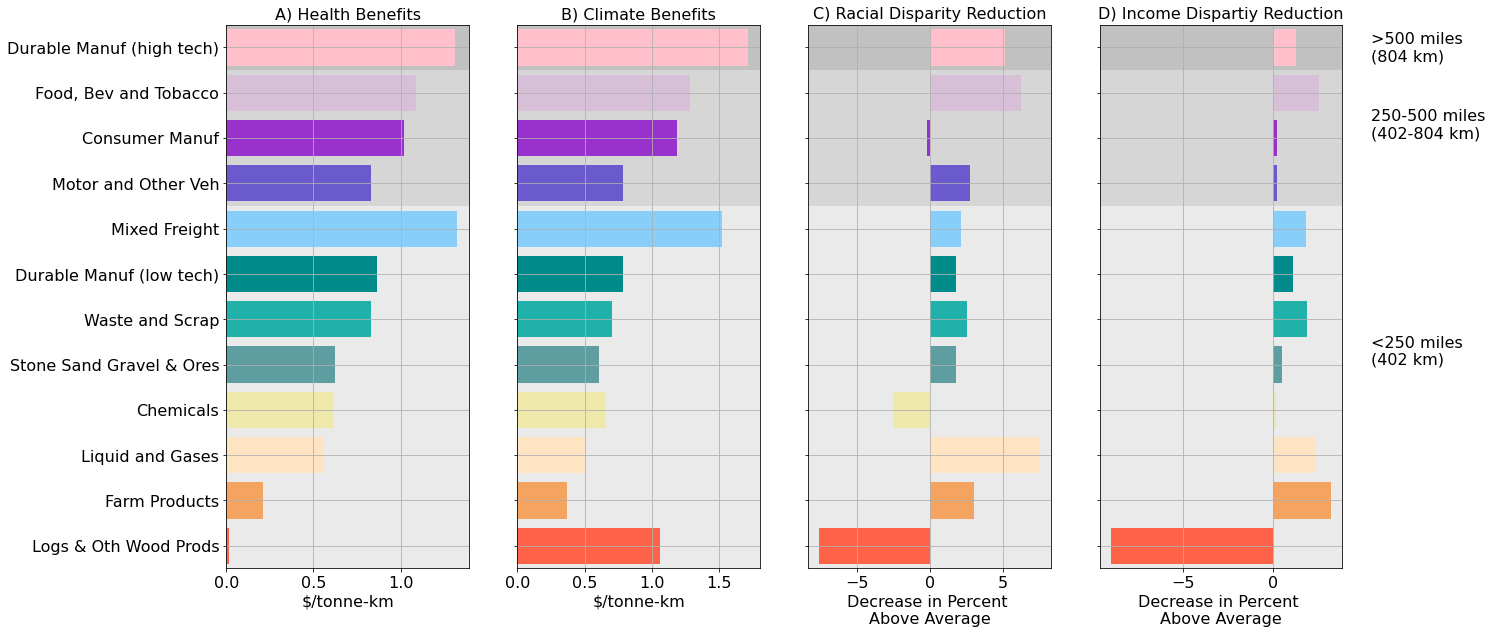

In [275]:
benefits_summary = pd.DataFrame(index = summary_table.commodity.unique(), 
                                columns = ["health_ben","climate_ben","health_tmile","climate_tmile","health_gap_race","health_gap_income","avg_dist"])
for c in benefits_summary.index:
    benefits_summary.loc[c,"health_ben"] = (summary_table.loc[(summary_table.scenario=="new_diesel") &
                 (summary_table.race=="All") &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_val"].sum() - 
                                           summary_table.loc[(summary_table.scenario=="base") &
                 (summary_table.race=="All") &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"deaths_val"].sum())
    benefits_summary.loc[c,"climate_ben"] = (summary_table.loc[(summary_table.scenario=="new_diesel") &
                 (summary_table.race=="All") &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"co2_value"].sum() - 
                                           summary_table.loc[(summary_table.scenario=="base") &
                 (summary_table.race=="All") &
                 (summary_table.income=="All") &
                 (summary_table.region=="All") & 
                 (summary_table.commodity==c) &
                 (summary_table.state=="All"),"co2_value"].sum())
    benefits_summary.loc[c,"health_tmile"] = net_benefit_tmile.loc[c,"damage_tmile_health"]
    benefits_summary.loc[c,"climate_tmile"] = net_benefit_tmile.loc[c,"damage_tmile_clim"]
    benefits_summary.loc[c,"health_gap_race"] = race_gap_benefits.loc[c,"race_gap_ratio"]
    benefits_summary.loc[c,"health_gap_income"] = race_gap_benefits.loc[c,"income_gap_ratio"]
    benefits_summary.loc[c,"avg_dist"] = net_benefit_tmile.loc[c,"miles_ton"]
    benefits_summary = benefits_summary.sort_values(by = "health_tmile")
    
f, ax = plt.subplots(1,4, figsize = (20,10))
ax = ax.flatten()

colors = ["tomato","sandybrown","bisque","palegoldenrod",
          "cadetblue","lightseagreen","darkcyan","lightskyblue",
          "slateblue","darkorchid","thistle","pink"]

short = benefits_summary[benefits_summary.avg_dist<250].sort_values(by = "health_tmile")
mid = benefits_summary[(benefits_summary.avg_dist>=250) & (benefits_summary.avg_dist<500)].sort_values(by = "health_tmile")
long = benefits_summary[benefits_summary.avg_dist>500].sort_values(by = "health_tmile")
print(len(short))
print(len(mid))
print(len(long))

ax[0].barh(width= short.health_tmile/1.459972, y = short.index, color = colors[0:len(short)])
ax[0].barh(width= mid.health_tmile/1.459972, y = mid.index, color = colors[len(short):len(short)+len(mid)])
ax[0].barh(width= long.health_tmile/1.459972, y = long.index, color = colors[len(short)+len(mid):])

ax[1].barh(width= short.climate_tmile/1.459972, y = short.index, color = colors[0:len(short)])
ax[1].barh(width= mid.climate_tmile/1.459972, y = mid.index, color = colors[len(short):len(short)+len(mid)])
ax[1].barh(width= long.climate_tmile/1.459972, y = long.index, color = colors[len(short)+len(mid):])

ax[2].barh(width= short.health_gap_race, y = short.index, color = colors[0:len(short)])
ax[2].barh(width= mid.health_gap_race, y = mid.index, color = colors[len(short):len(short)+len(mid)])
ax[2].barh(width= long.health_gap_race, y = long.index, color = colors[len(short)+len(mid):])

ax[3].barh(width= short.health_gap_income, y = short.index, color = colors[0:len(short)])
ax[3].barh(width= mid.health_gap_income, y = mid.index, color = colors[len(short):len(short)+len(mid)])
ax[3].barh(width= long.health_gap_income, y = long.index, color = colors[len(short)+len(mid):])



labels = short.index.append(mid.index).append(long.index)


for a in ax[1:]:
    a.grid()
    a.set_yticklabels([])
ax[0].set_yticklabels(labels.str[4:-8], fontsize = 16)
ax[0].grid()
ax[0].set_title("A) Health Benefits", fontsize = 16)
ax[1].set_title("B) Climate Benefits", fontsize = 16)
ax[2].set_title("C) Racial Disparity Reduction", fontsize = 16)
ax[3].set_title("D) Income Dispartiy Reduction", fontsize = 16)
ax[0].set_xlabel("$/tonne-km", fontsize = 16)
ax[1].set_xlabel("$/tonne-km", fontsize = 16)
ax[2].set_xlabel("Decrease in Percent \nAbove Average", fontsize = 16)
ax[3].set_xlabel("Decrease in Percent \nAbove Average", fontsize = 16)

for a in ax:
    for tick in a.get_xticklabels():
        tick.set_fontsize(16)


for a in ax:
    a.axhspan(-0.5, len(short)-.5, facecolor='0.2', alpha=0.1, zorder = -100)
    a.axhspan(len(short)-.5, len(short)-.5+len(mid), facecolor='0.2', alpha=0.2, zorder = -100)
    a.axhspan(len(short)-.5+len(mid), len(benefits_summary), facecolor='0.2', alpha=0.3, zorder = -100)
    a.set_ylim(-0.5,len(benefits_summary)-0.5 )
ax[3].text(5.5, 10.7,">500 miles\n(804 km)", fontsize = 16)
ax[3].text(5.5, 9,"250-500 miles\n(402-804 km)", fontsize = 16)
ax[3].text(5.5, 4,"<250 miles\n(402 km)", fontsize = 16)


ax[0].locator_params(axis='x', nbins=5)
ax[1].locator_params(axis='x', nbins=6)
ax[2].locator_params(axis='x', nbins=6)
ax[3].locator_params(axis='x', nbins=5)

# ax[3].annotate('SDL', xy=(0.5, 0.90), xytext=(0.5, 1.00), xycoords='axes fraction', 
#             fontsize=16, ha='center', va='bottom',
#             arrowprops=dict(arrowstyle='-[, widthB=7.0, lengthB=1.5', lw=2.0))

f.savefig("ben_summary_tmile_ratio_dist2.png", bbox_inches = "tight")


## Imports and exports

In [109]:
imports = attach_demographics(diesel_deaths_i["fleet_avg"]["TOT Tons_22 Imp"], demographics)
exports = attach_demographics(diesel_deaths_e["fleet_avg"]["TOT Tons_22 Exp"], demographics)
total = attach_demographics(diesel_deaths["fleet_avg"]["TOT Tons_22 All"], demographics)
state_deaths_pc_i, state_deaths_i = make_state_death_tables(imports)
state_deaths_pc_e, state_deaths_e = make_state_death_tables(exports)
state_deaths_pc_t, state_deaths_t = make_state_death_tables(total)

/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_44737/3529939156.py:10: RuntimeWarning: invalid value encountered in double_scalars
  state_deaths_pc.loc[dem, state] = df.loc[df["STATEFP"]==state,f"{dem}_deathsK"].sum()/df.loc[df["STATEFP"]==state,f"{dem}_pop"].sum()*100000
/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_44737/3529939156.py:11: RuntimeWarning: invalid value encountered in double_scalars
  totals = pd.Series({state: df.loc[df["STATEFP"]==state,"deathsK"].sum()/df.loc[df["STATEFP"]==state,"Population"].sum()*100000 for state in state_deaths_pc.columns})
/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_44737/3529939156.py:10: RuntimeWarning: invalid value encountered in double_scalars
  state_deaths_pc.loc[dem, state] = df.loc[df["STATEFP"]==state,f"{dem}_deathsK"].sum()/df.loc[df["STATEFP"]==state,f"{dem}_pop"].sum()*100000
/var/folders/vy/0842xjfx7l38y0jjvdqx_6sc0000gn/T/ipykernel_44737/3529939156.py:11: RuntimeWarning: invalid value enco

In [150]:
imp_exp = pd.DataFrame(index = state_deaths_t.columns, columns = ["Imports","Exports","Total"])
for s in imp_exp.index:
    imp_exp.loc[s,"Imports"] = state_deaths_i.loc[incomes,s].sum()
    imp_exp.loc[s,"Exports"] = state_deaths_e.loc[incomes,s].sum()
    imp_exp.loc[s,"Total"] = state_deaths_t.loc[incomes,s].sum()
imp_exp["Domestic"] = imp_exp["Total"] - imp_exp["Exports"] - imp_exp["Imports"]

In [168]:
imp_exp_pct = imp_exp.copy()
for c in ["Imports","Exports","Domestic"]:
    imp_exp_pct[c]/=imp_exp["Total"]
    imp_exp_pct[c]*=100
imp_exp_pct = imp_exp_pct.astype(float)

In [169]:
imp_exp_pct_geo = states.merge(imp_exp_pct, how = "inner", left_on = "STATEFP", right_index = True)

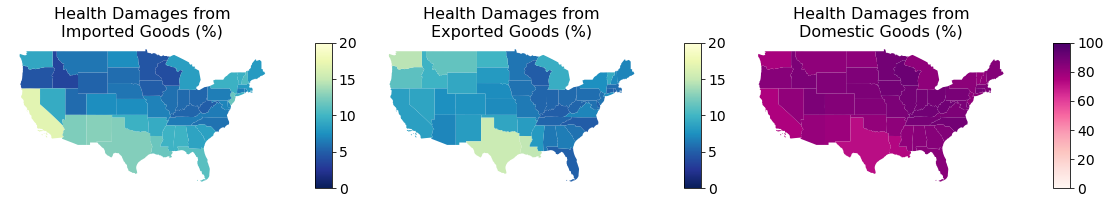

In [204]:
f, ax = plt.subplots(1,3, figsize = (16,3))
ax = ax.flatten()
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize = 14)
imp_exp_pct_geo.plot(column = "Imports", legend = True, cmap = "YlGnBu_r", vmax = 20, vmin = 0, ax = ax[0], cax = cax)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize = 14)
imp_exp_pct_geo.plot(column = "Exports", legend = True, cmap = "YlGnBu_r", vmax = 20, vmin = 0, ax = ax[1], cax = cax)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.05)
cax.tick_params(labelsize = 14)
imp_exp_pct_geo.plot(column = "Domestic", legend = True, cmap = "RdPu", vmax = 100, vmin = 0, ax = ax[2], cax = cax)

for a in ax:
    a.set_yticks([])
    a.set_xticks([])
    a.axis("off")
plt.tight_layout()
ax[0].set_title("Health Damages from\nImported Goods (%)", fontsize = 16)
ax[1].set_title("Health Damages from\nExported Goods (%)", fontsize = 16)
ax[2].set_title("Health Damages from\nDomestic Goods (%)", fontsize = 16)
f.savefig("imp_exp.png")